In [1]:
__depends__ = ["/Volumes/Seagate Expansion Drive/seq1_jcole_gene-editing_gene-editing_multiple/multiple"]
__dest__ = []

Summarize results from the gene editing scenarion in which the top 1% of bulls and no (0%) cows were edited for the horned locus.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.mpl_style = 'default'
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import seaborn as sns

/home/jcole/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jcole/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
print pd.__version__

0.18.0


In [4]:
plt.rcdefaults()
# Typeface sizes
from matplotlib import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
#rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Computer Modern Roman']
#rcParams['text.usetex'] = True

# Optimal figure size
WIDTH = 350.0  # the number latex spits out
FACTOR = 0.90  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims      = [fig_width_in, fig_height_in] # fig dims as a list

rcParams['figure.figsize'] = fig_dims

In [5]:
methods = ['noedits', 'zfn', 'talen', 'crispr', 'perfect']
for method in methods:
    # We have 10 relicates for each simulation
    for sim in xrange(1,11):
        # Load the individual allele frequency history files
        af = pd.read_csv('multiple/10_01/%s/%s/minor_allele_frequencies_%s.txt'%(method,sim, method), sep='\t')
        af.columns = ['generation', 'Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS',
                     'Mulefoot', 'Horned', 'Red']
        af['replicate'] = sim
        af['method'] = method
        if sim == 1 and method == methods[0]:
            all_replicates = af
        else:
            all_replicates = pd.concat([all_replicates, af])

In [6]:
all_replicates.head()

generation  Brachyspina       HH1       HH2       HH3       HH4       HH5  \
0           1     0.022631  0.019531  0.025086  0.045859  0.013823  0.023294   
1           2     0.023418  0.015979  0.021328  0.039571  0.014119  0.027221   
2           3     0.018947  0.014398  0.017793  0.050200  0.016640  0.023125   
3           4     0.019478  0.015746  0.018771  0.042677  0.016040  0.021587   
4           5     0.020896  0.013144  0.019025  0.038761  0.016413  0.018313   

       BLAD       CVM     DUMPS  Mulefoot    Horned       Red  replicate  \
0  0.009452  0.019521  0.007471  0.003565  0.991562  0.054429          1   
1  0.016376  0.024504  0.006736  0.003162  0.992930  0.054950          1   
2  0.016066  0.039436  0.006071  0.002791  0.994059  0.050924          1   
3  0.015010  0.057090  0.005766  0.009363  0.994846  0.042478          1   
4  0.012871  0.059512  0.005189  0.013353  0.995716  0.040776          1   

    method  
0  noedits  
1  noedits  
2  noedits  
3  noedits  
4  noedits

In [7]:
all_replicates = pd.melt(all_replicates,
                         id_vars = ['generation', 'replicate', 'method'],
                         value_vars = ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM',
                                       'DUMPS', 'Mulefoot', 'Horned', 'Red'],
                        var_name = 'recessive',
                        value_name = 'frequency')

In [8]:
all_replicates.head()

generation  replicate   method    recessive  frequency
0           1          1  noedits  Brachyspina   0.022631
1           2          1  noedits  Brachyspina   0.023418
2           3          1  noedits  Brachyspina   0.018947
3           4          1  noedits  Brachyspina   0.019478
4           5          1  noedits  Brachyspina   0.020896

In [9]:
grouped = all_replicates.groupby(['generation', 'method', 'recessive']).mean().reset_index()
grouped.head()

generation  method    recessive  replicate  frequency
0           1  crispr         BLAD        5.5   0.009812
1           1  crispr  Brachyspina        5.5   0.033415
2           1  crispr          CVM        5.5   0.017348
3           1  crispr        DUMPS        5.5   0.004434
4           1  crispr          HH1        5.5   0.027841

In [10]:
expected = {}
actual = {}

for r in ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS', 'Mulefoot', 'Horned', 'Red']:
    expected[r] = {}
    actual[r] = {}
    for method in methods:
        expected[r][method] = []
        actual[r][method] = []
        # Red and horned are NOT lethals
        if r in ['Horned', 'Red']:
            for g in xrange(1,21):
                if g == 1:
                    expected[r][method].append(float(grouped[(grouped['generation']==g) & 
                                                             (grouped['method']==method) &
                                                             (grouped['recessive']==r)]
                                                     ['frequency']))
                else:
                    q0 = expected[r][method][g-2]
                    p0 = 1. - q0
                    q1 = (p0*q0) + q0**2
                    #print 'g: ', g, ', q0: ', q0, ', p0: ', p0, ', q1: ', q1
                    expected[r][method].append(q1)
                actual[r][method].append(float(grouped[(grouped['generation']==g) &
                                                 (grouped['method']==method) &
                                                 (grouped['recessive']==r)]
                                               ['frequency']))

        # The other recessives are lethals        
        else:
            for g in xrange(1,21):
                if g == 1:
                    expected[r][method].append(float(grouped[(grouped['generation']==g) & 
                                                             (grouped['method']==method) &
                                                             (grouped['recessive']==r)]
                                                     ['frequency']))
                else:
                    q0 = expected[r][method][g-2]
                    p0 = 1. - q0
                    q1 = (p0*q0) / (p0**2 + (2*p0*q0))
                    #print 'g: ', g, ', q0: ', q0, ', p0: ', p0, ', q1: ', q1
                    expected[r][method].append(q1)
                actual[r][method].append(float(grouped[(grouped['generation']==g) &
                                                 (grouped['method']==method) &
                                                 (grouped['recessive']==r)]
                                               ['frequency']))
#for k in expected[r].keys():
#print k, ':\t', expected[r][k], '\n'
    
print expected['HH1']['talen']
print
print actual['HH1']['talen']

[0.02608704447802, 0.025423812354331714, 0.02479346787935387, 0.0241936240388612, 0.02362211936396825, 0.02307699190658946, 0.022556456737027736, 0.02205888641983179, 0.021582794017966835, 0.021126818251392017, 0.020689710498026297, 0.02027032337568206, 0.01986760068509624, 0.019480568528454256, 0.019108327446174904, 0.018750045438309035, 0.018404951756583215, 0.018072331369596798, 0.01775152001752604, 0.017441899784360285]

[0.02608704447802, 0.027833617400319997, 0.0276346832592, 0.02651890547263, 0.024953233830849998, 0.024724875621898, 0.024184577114421, 0.023197014925373998, 0.022178606965167998, 0.021118407960197, 0.019297512437796, 0.017764179104479, 0.015446268656717, 0.013465671641787996, 0.011826865671643, 0.010360199004965999, 0.0095119402985029, 0.008421393034832901, 0.0087318407960201, 0.008315422885564]


Brachyspina


/home/jcole/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


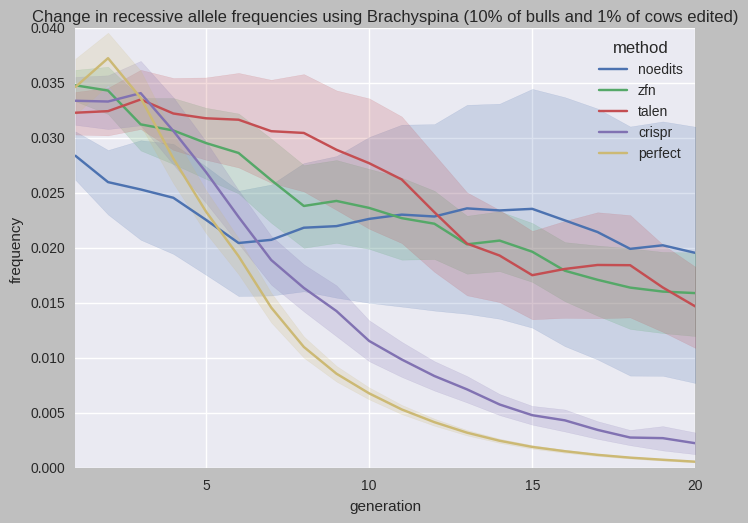

HH1


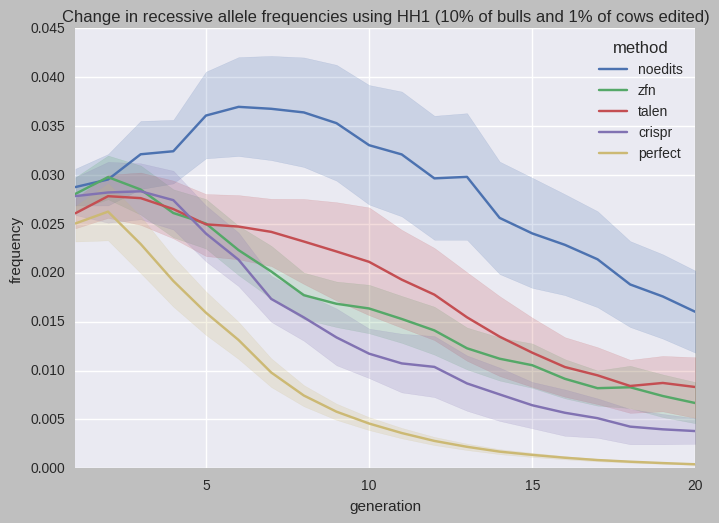

HH2


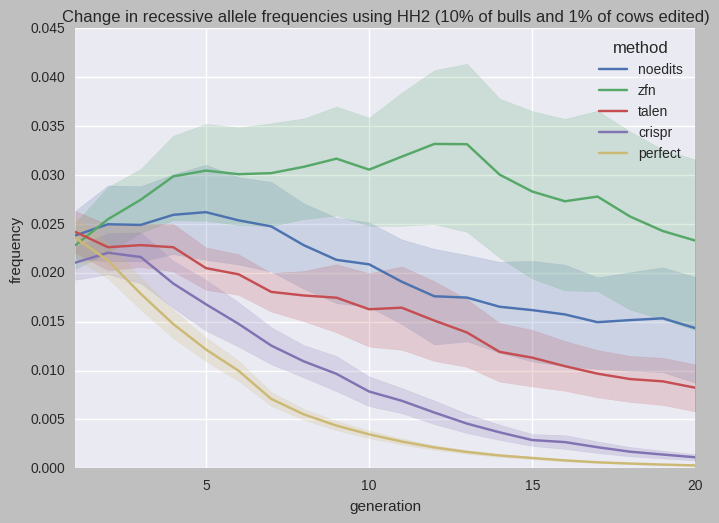

HH3


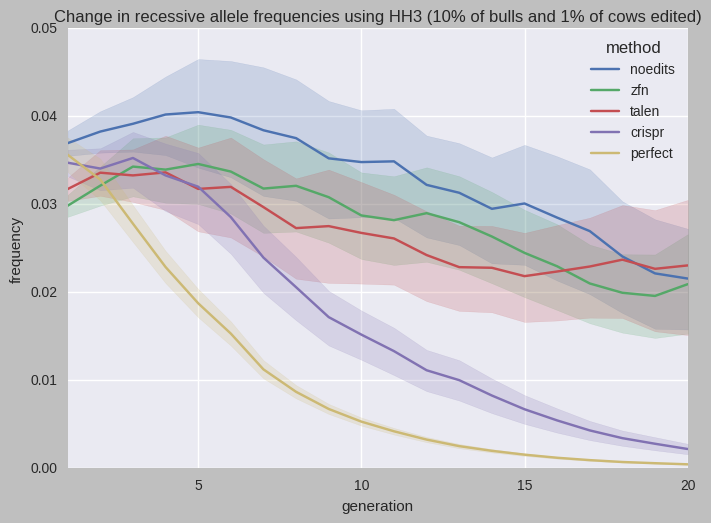

HH4


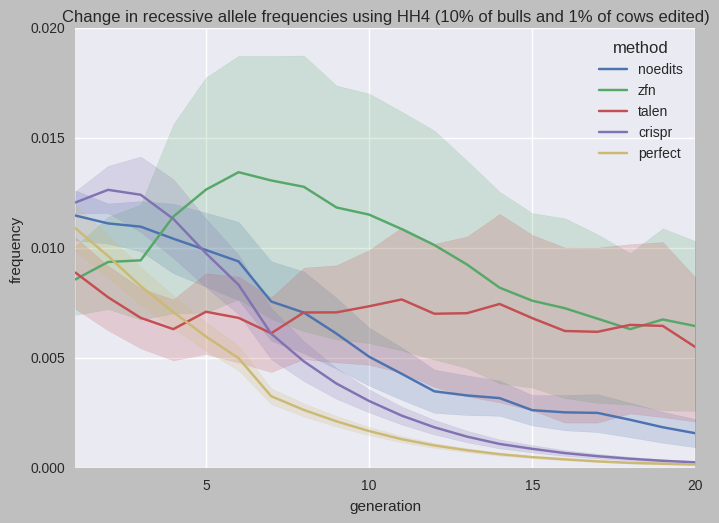

HH5


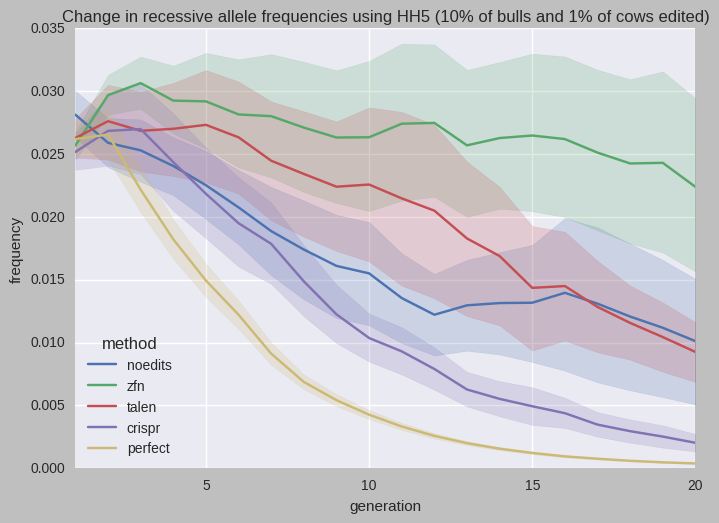

BLAD


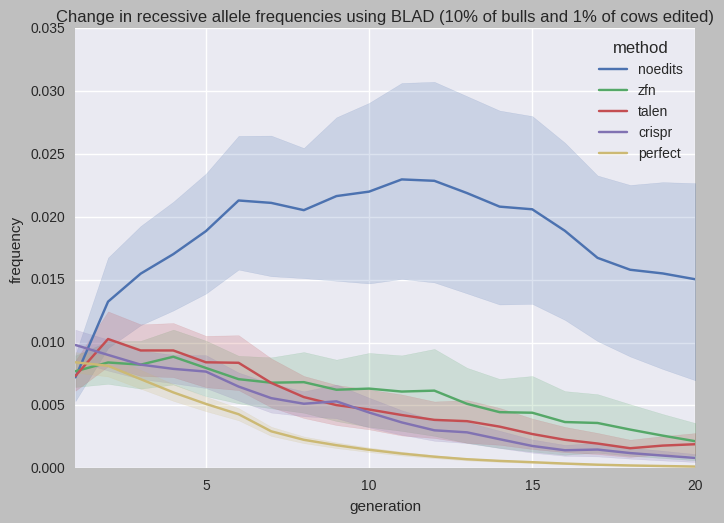

CVM


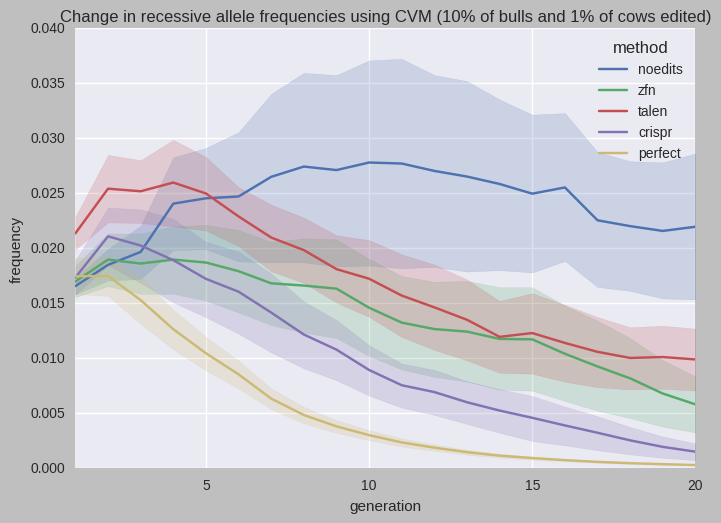

DUMPS


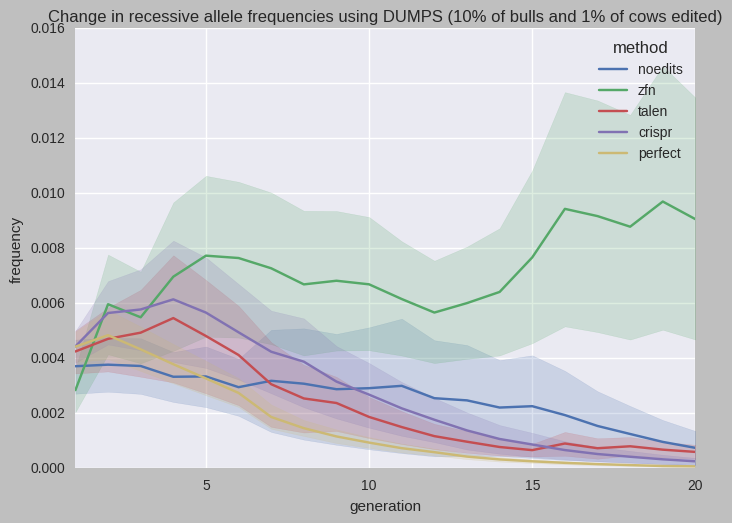

Mulefoot


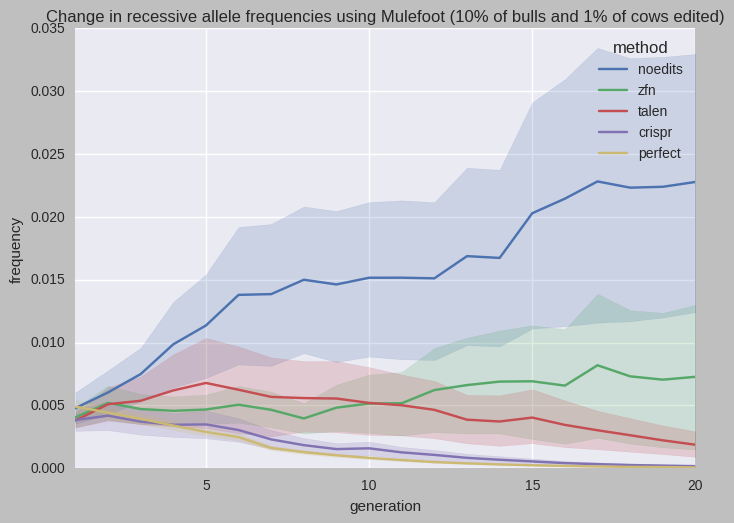

Horned


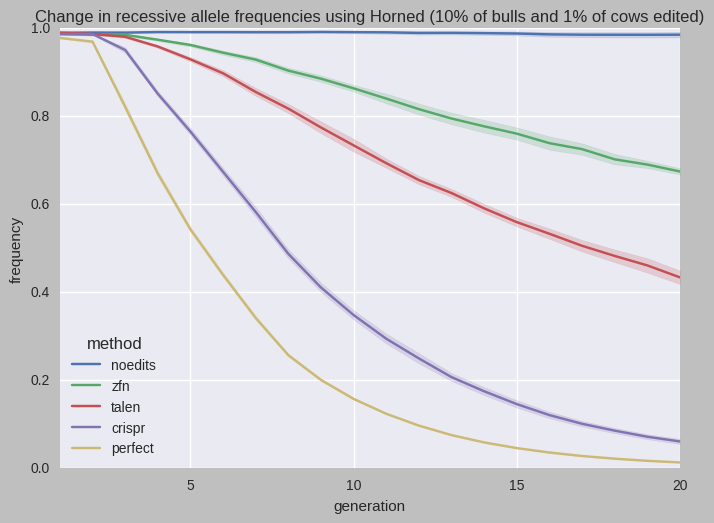

Red


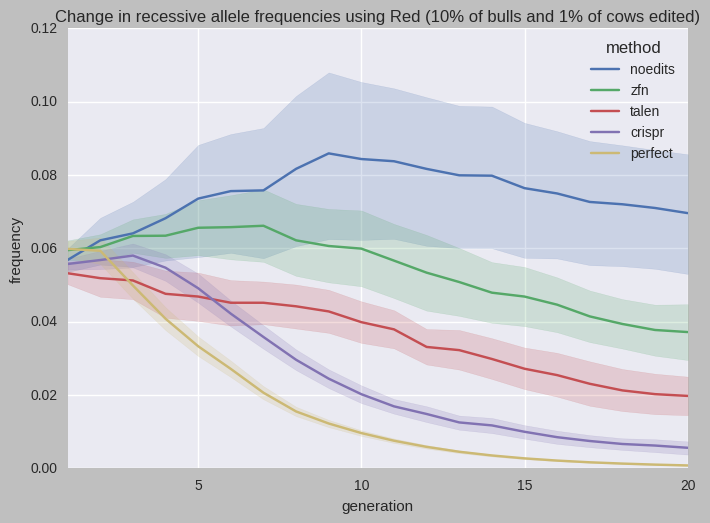

In [11]:
sns.set(style="darkgrid")
for r in all_replicates['recessive'].unique():
    print r
    #sns.tsplot(data=grouped, time="generation", unit="replicate", condition="method", value="frequency")
    sns_plot = sns.tsplot(data=all_replicates[all_replicates['recessive']==r], time="generation", unit="replicate",
               condition="method", value="frequency")
    sns.plt.title('Change in recessive allele frequencies using %s (10%% of bulls and 1%% of cows edited)'%(r))
    plt.show()
    sns_plot.get_figure().savefig('multiple/10_01/rate_of_allele_frequency_change_multiple_10_01_%s.png'%(r), dpi=300)

crispr


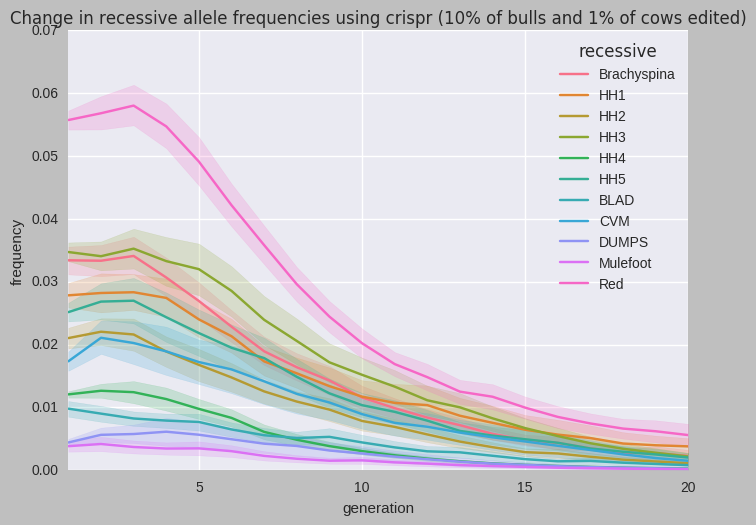

noedits


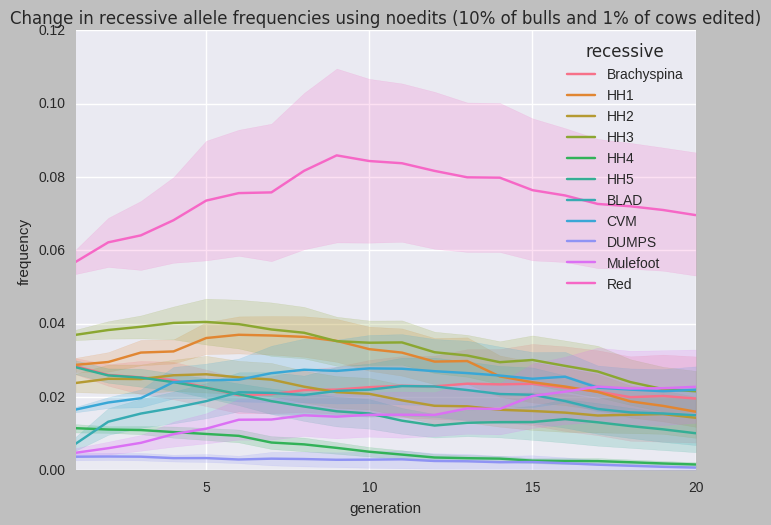

perfect


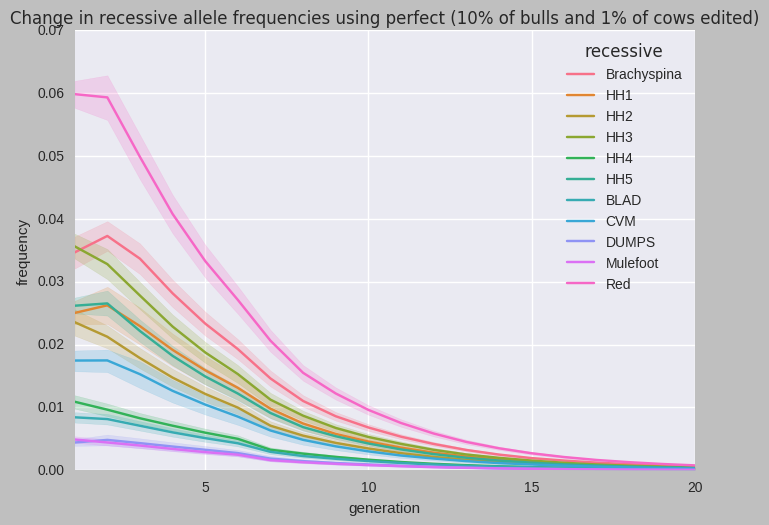

talen


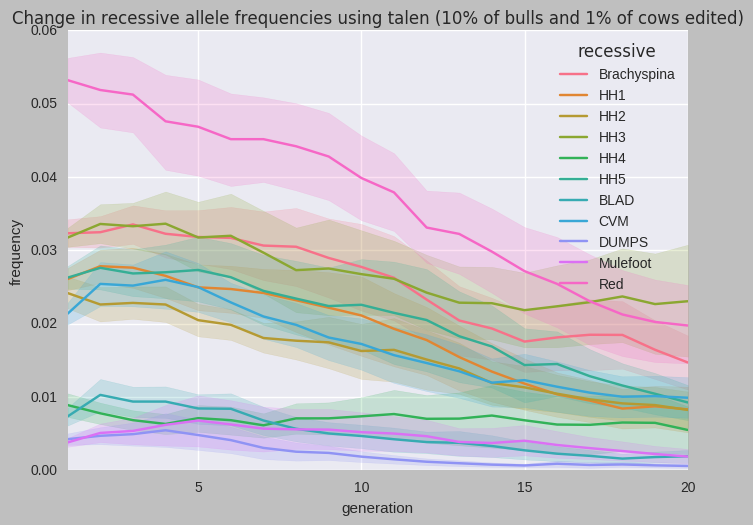

zfn


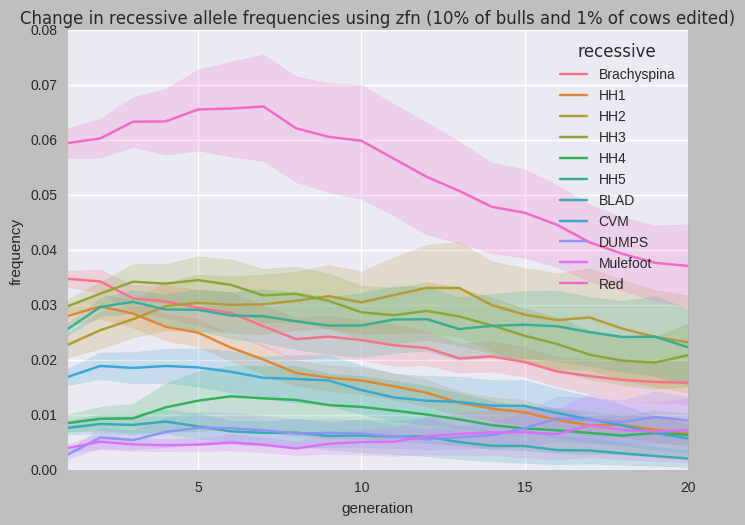

In [29]:
sns.set(style="darkgrid")
for m in all_replicates['method'].unique():
    print m
    sns_plot = sns.tsplot(data=all_replicates[(all_replicates['method']==m) & (all_replicates['recessive'] != 'Horned')],
               time="generation", unit="replicate", condition="recessive", value="frequency")
    sns.plt.title('Change in recessive allele frequencies using %s (10%% of bulls and 1%% of cows edited)'%(m))
    plt.show()
    sns_plot.get_figure().savefig('multiple/10_01/rate_of_allele_frequency_change_multiple_10_01_%s.png'%(m), dpi=300)

Now we have to load the animal records so that we can compute the cumulative genetic gain for each gene editing method.

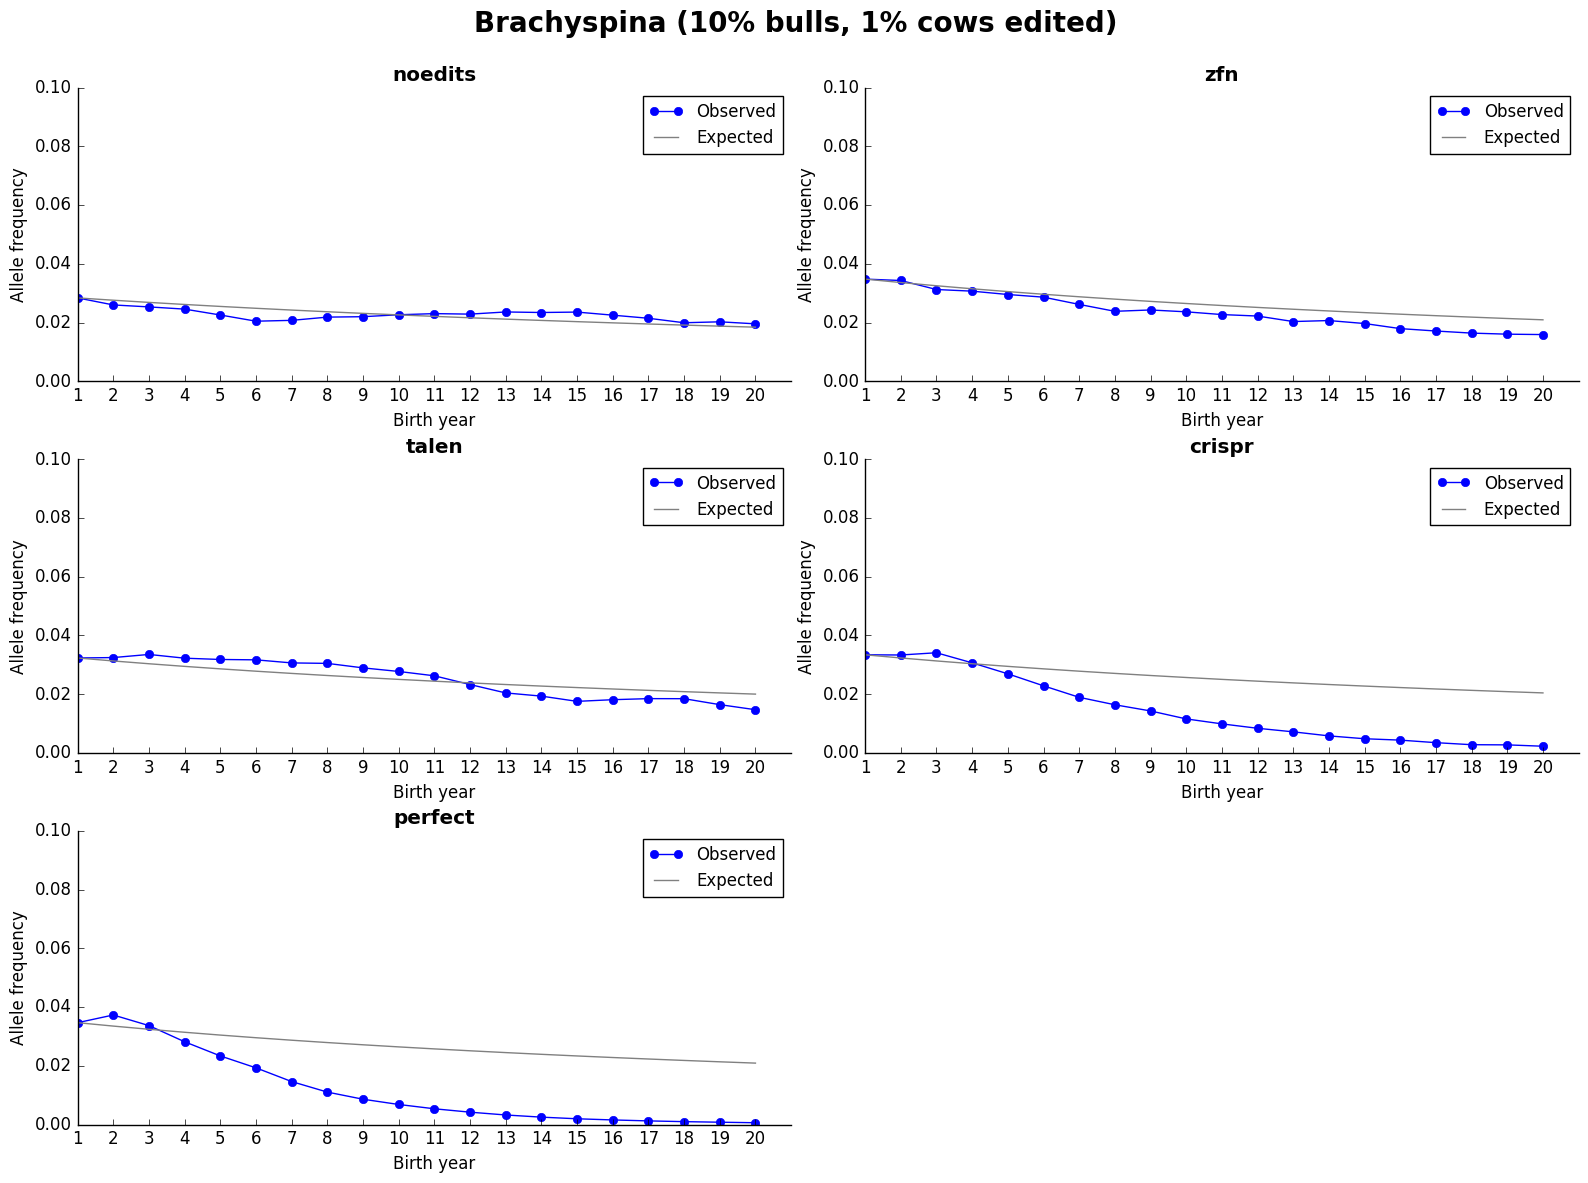

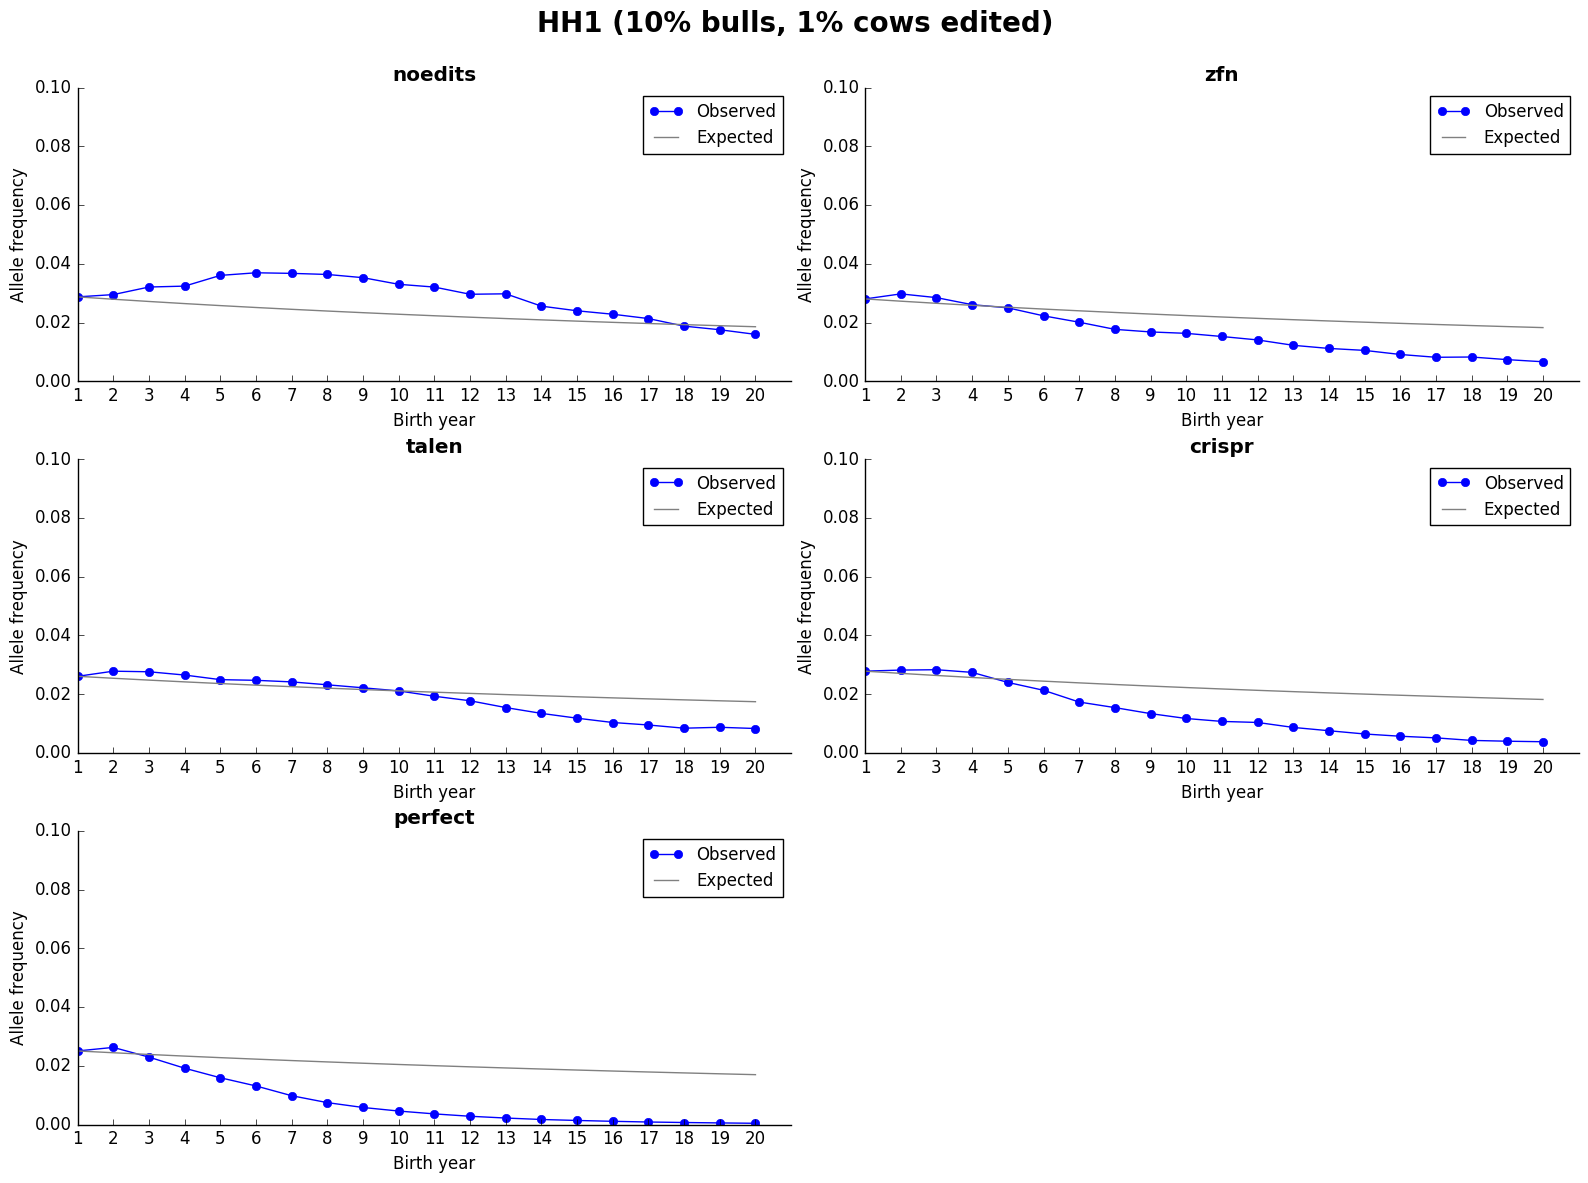

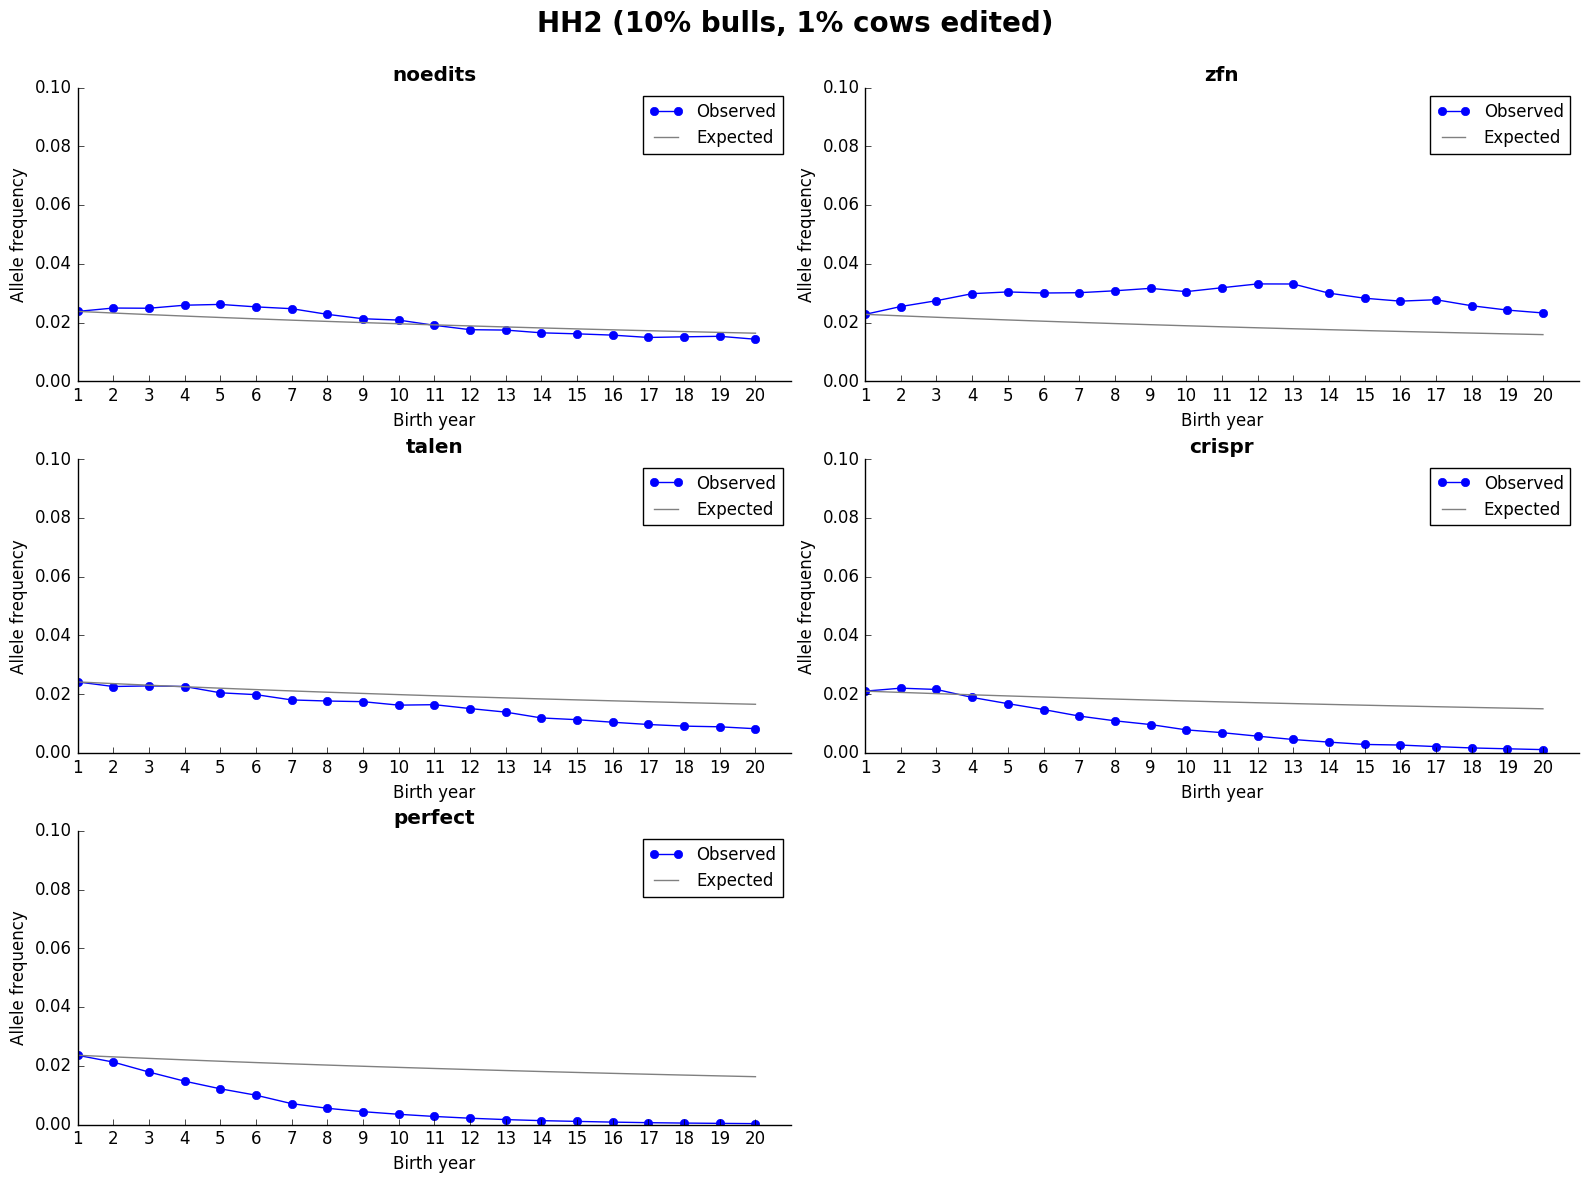

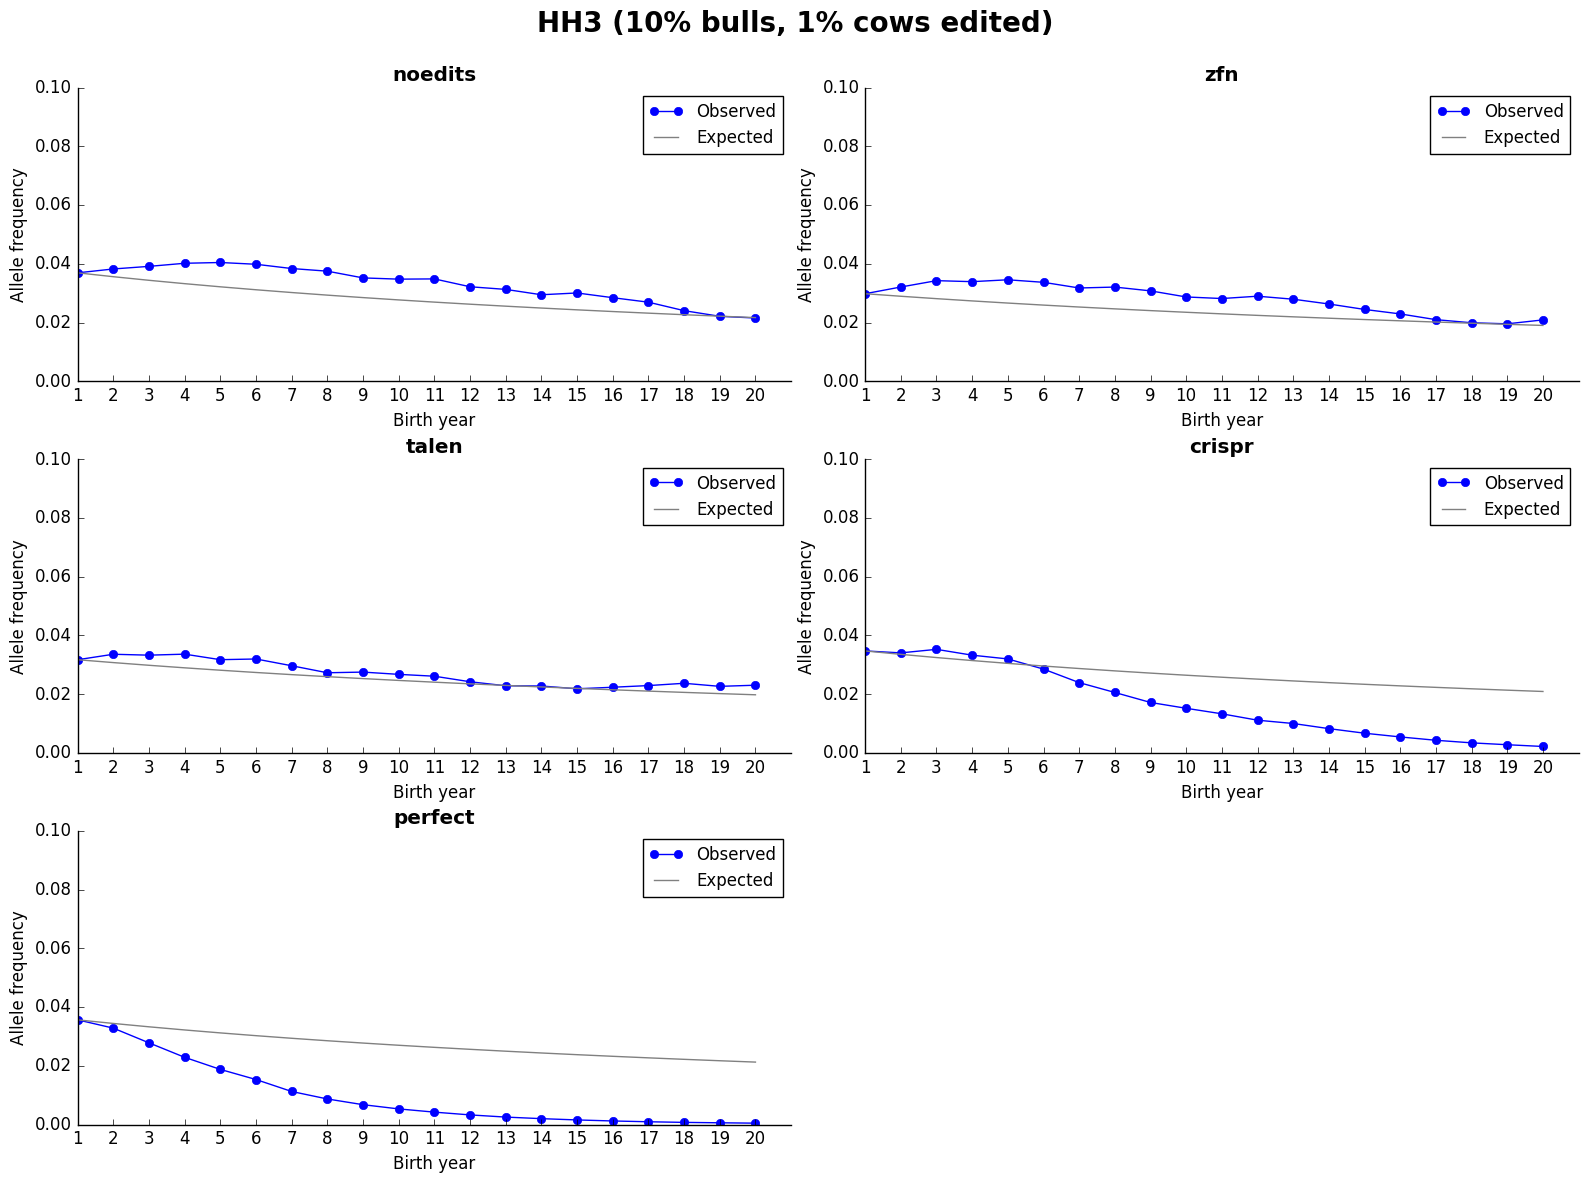

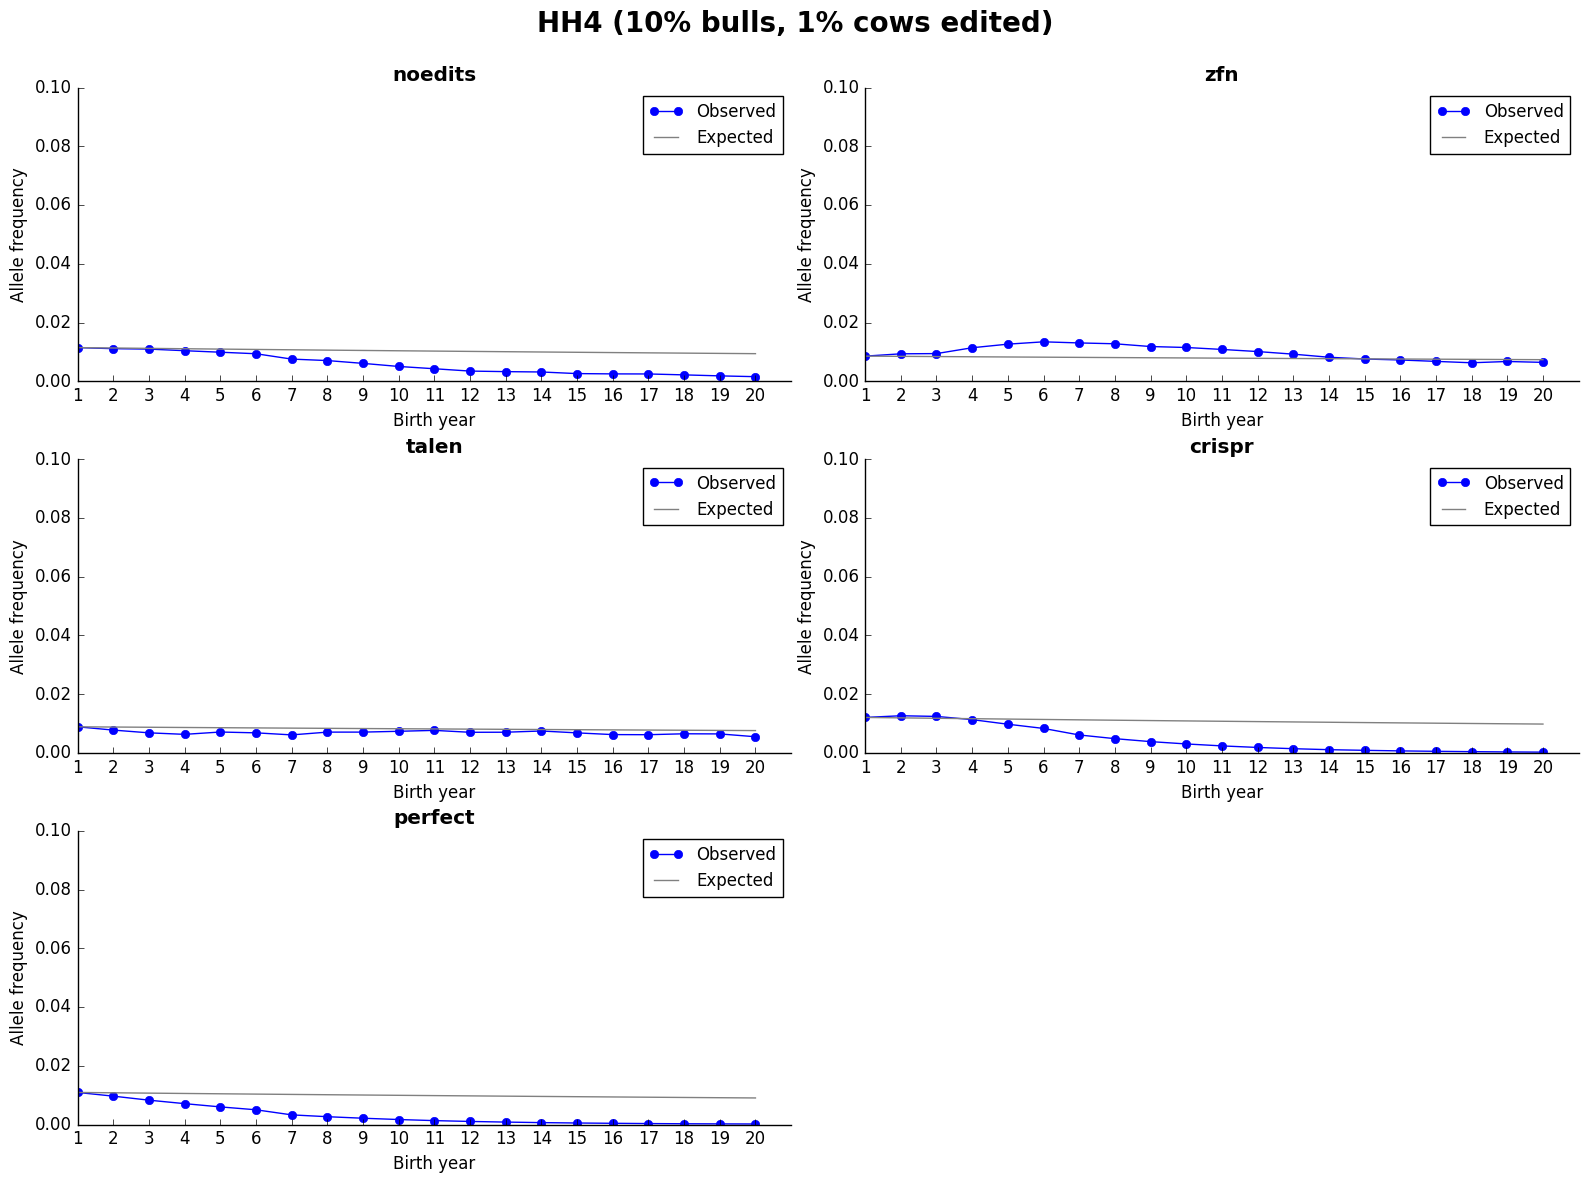

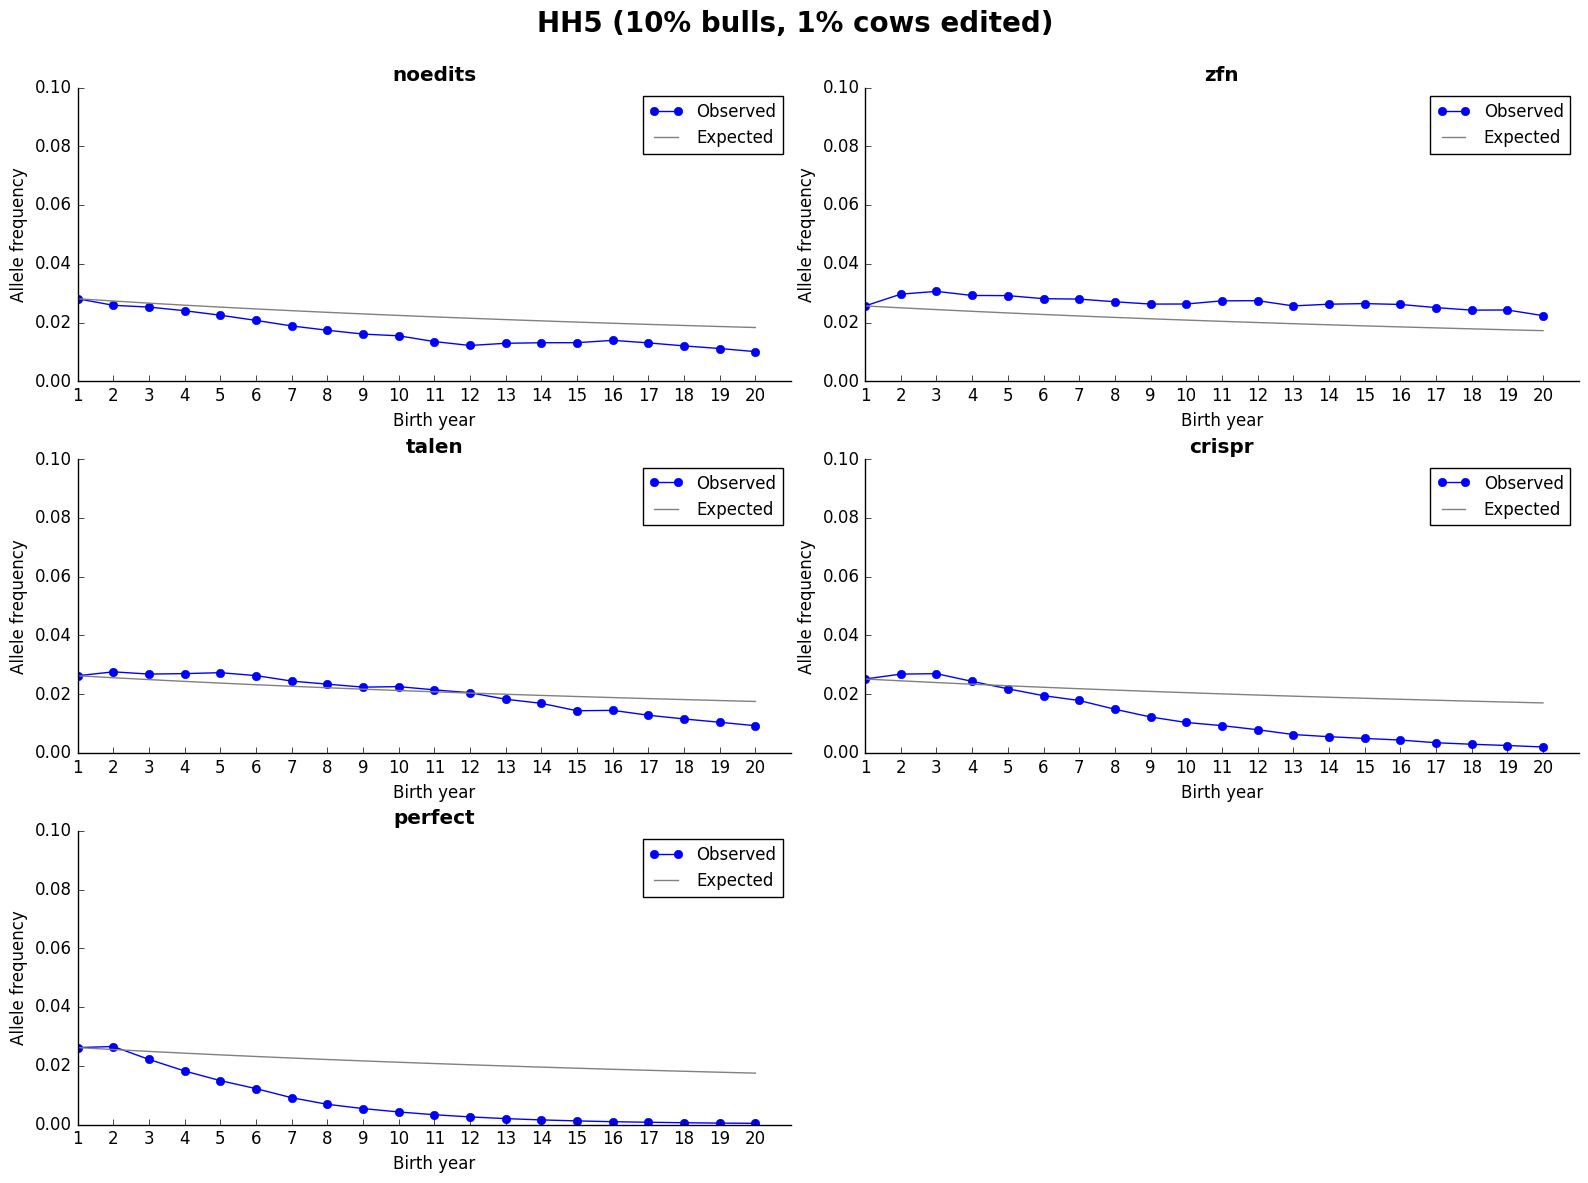

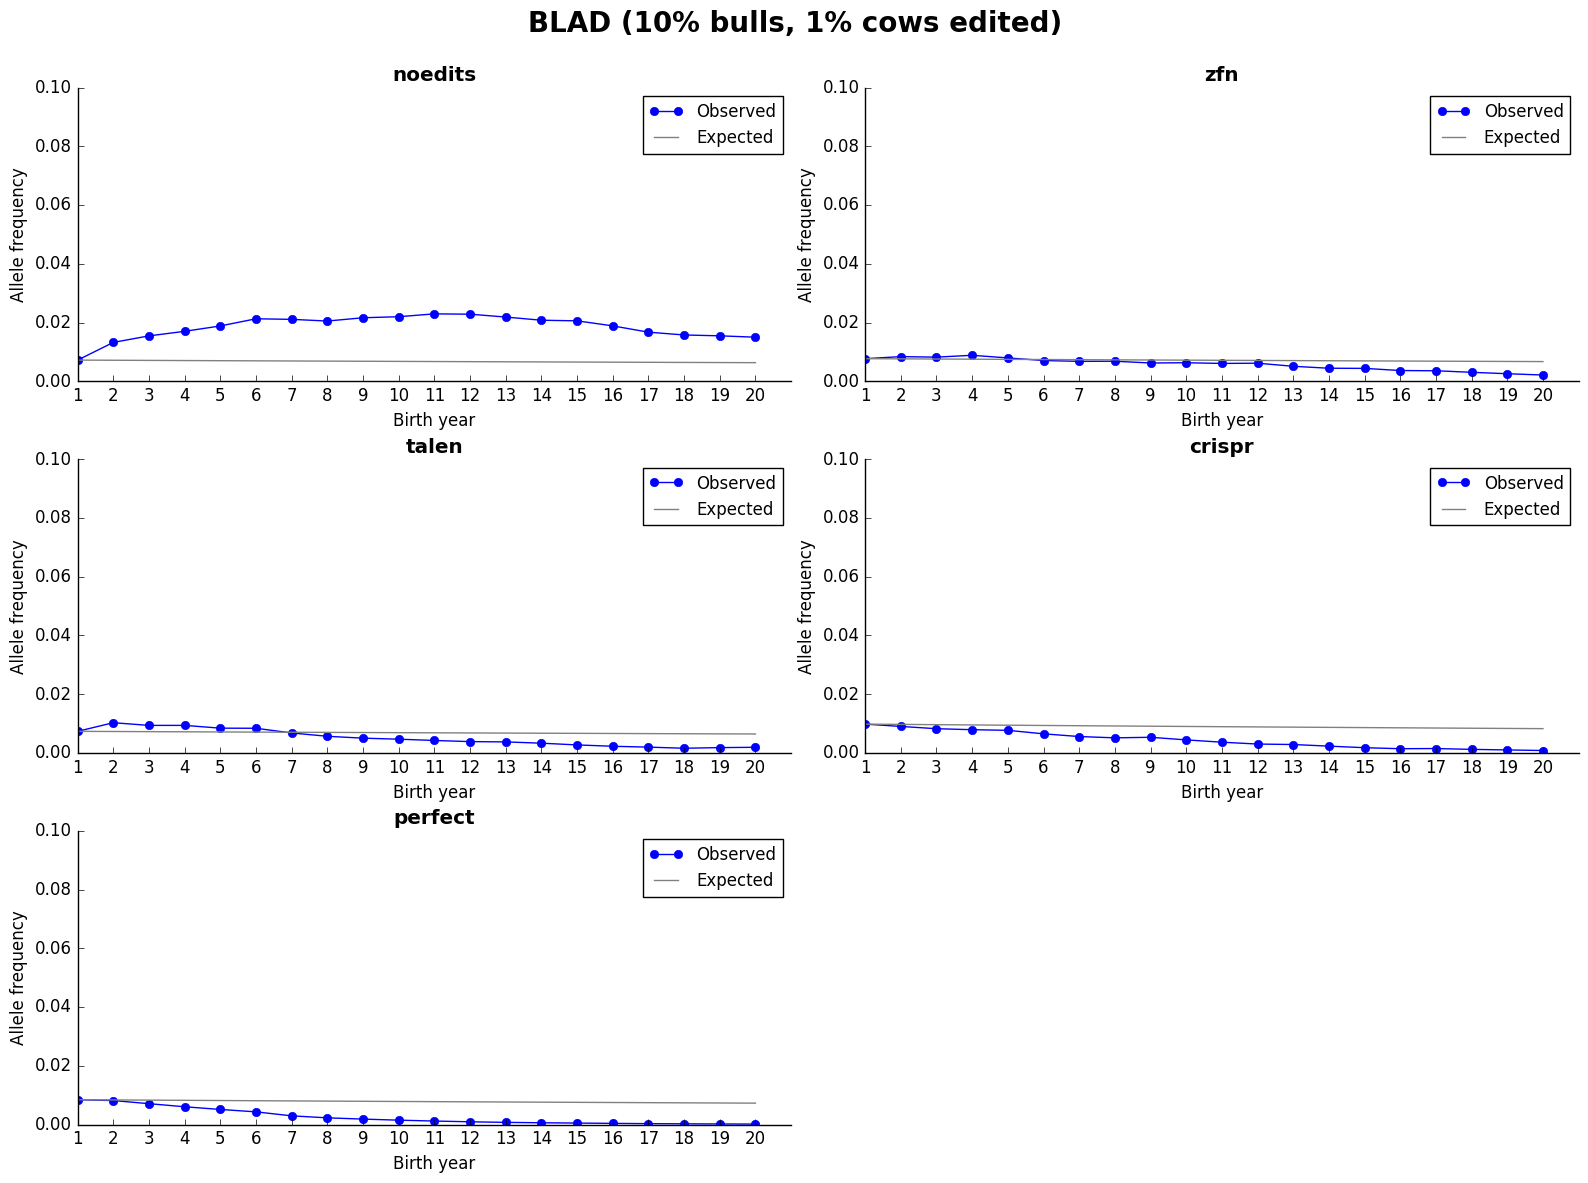

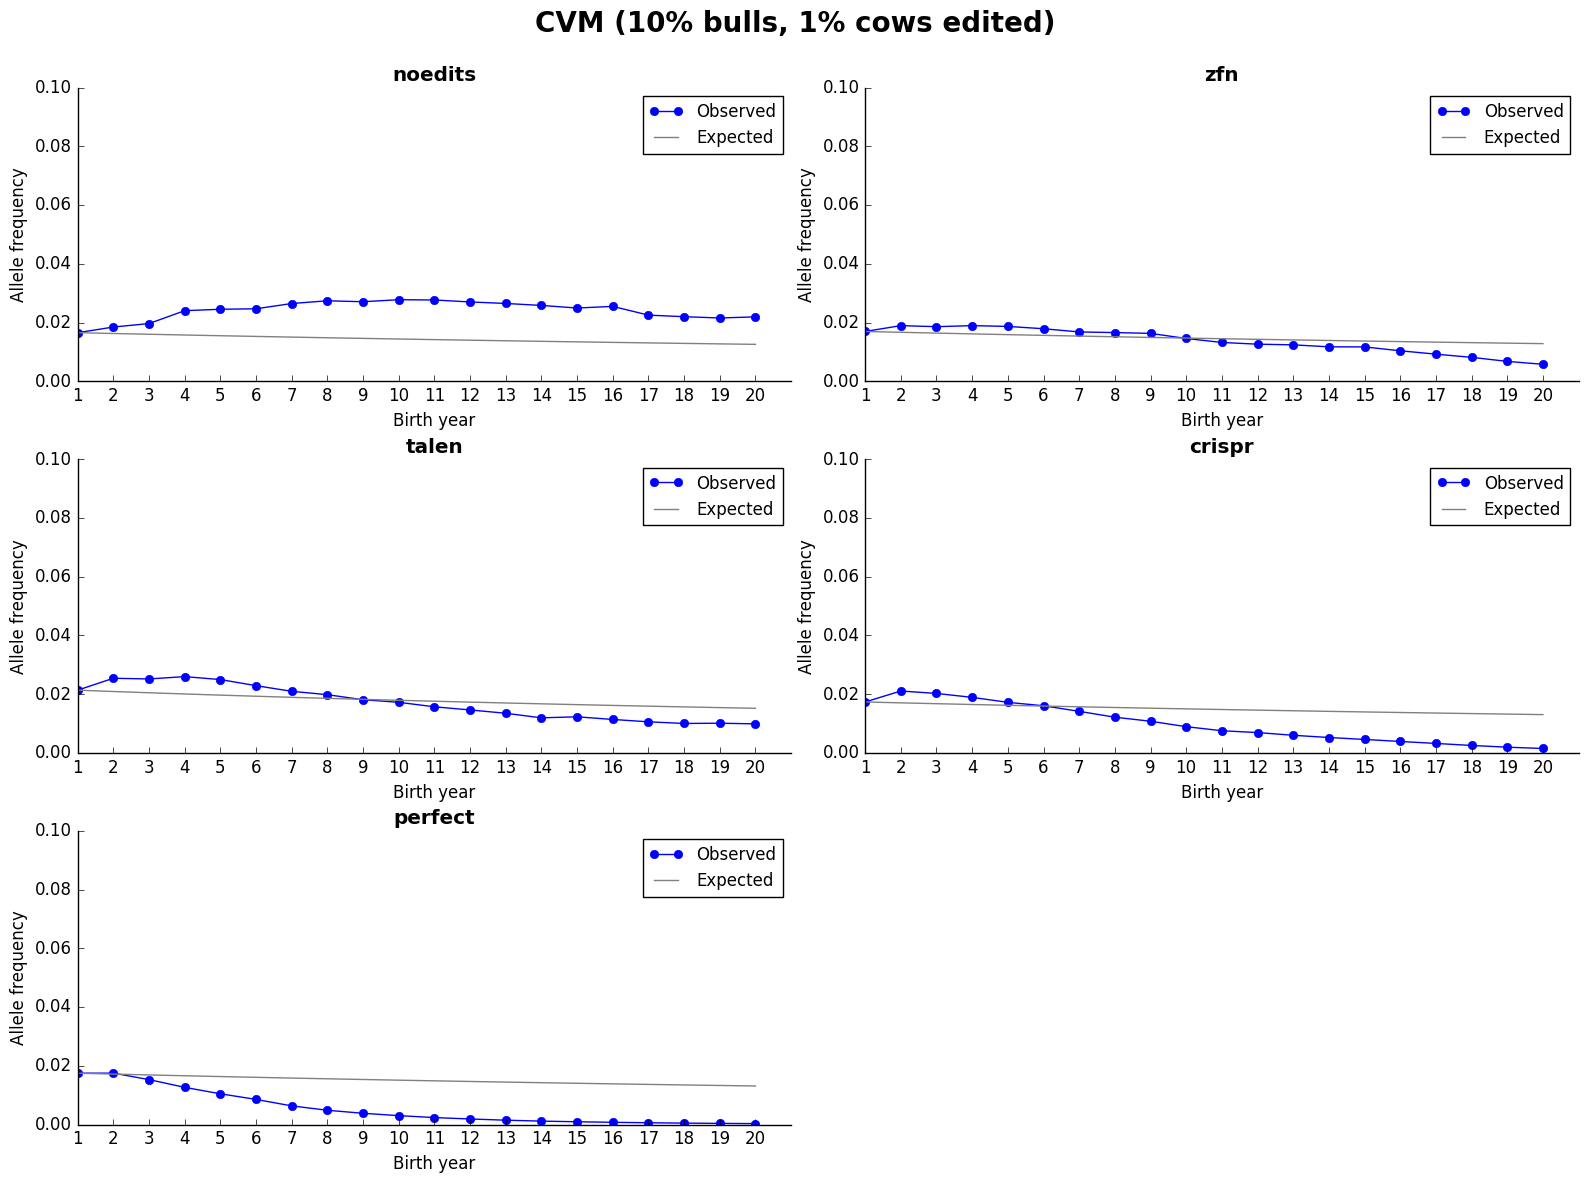

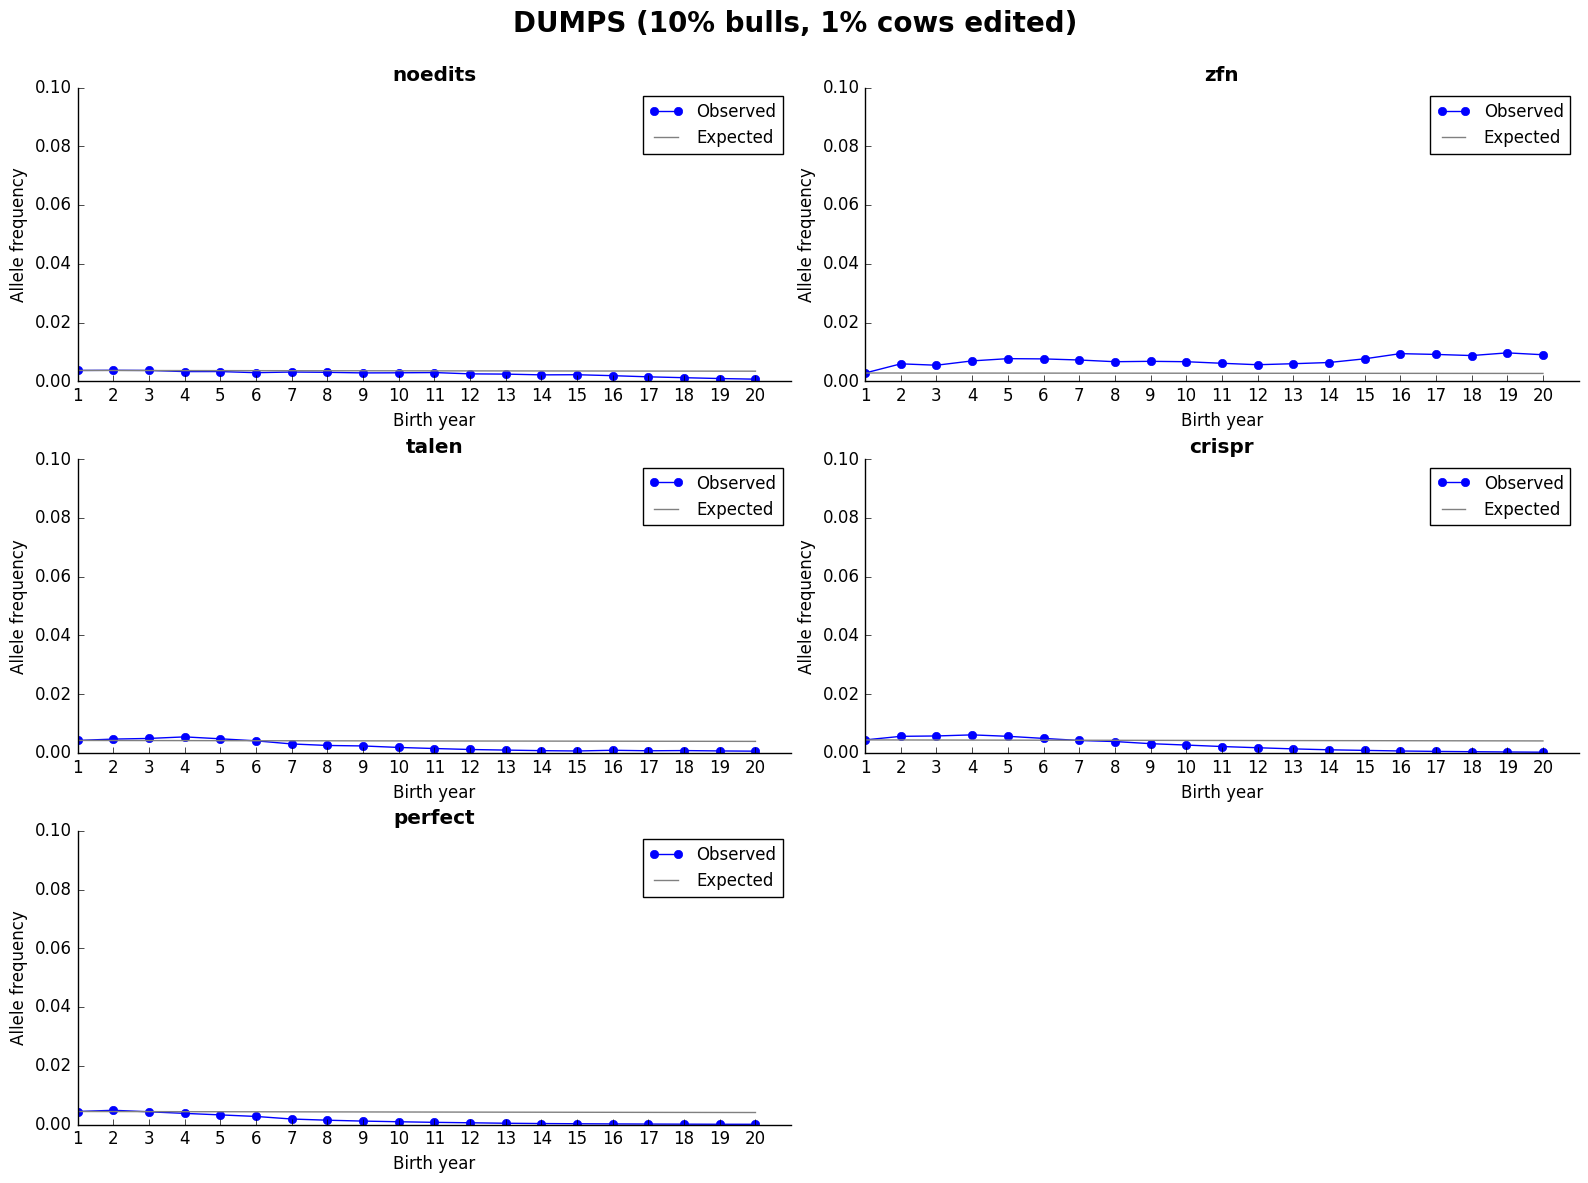

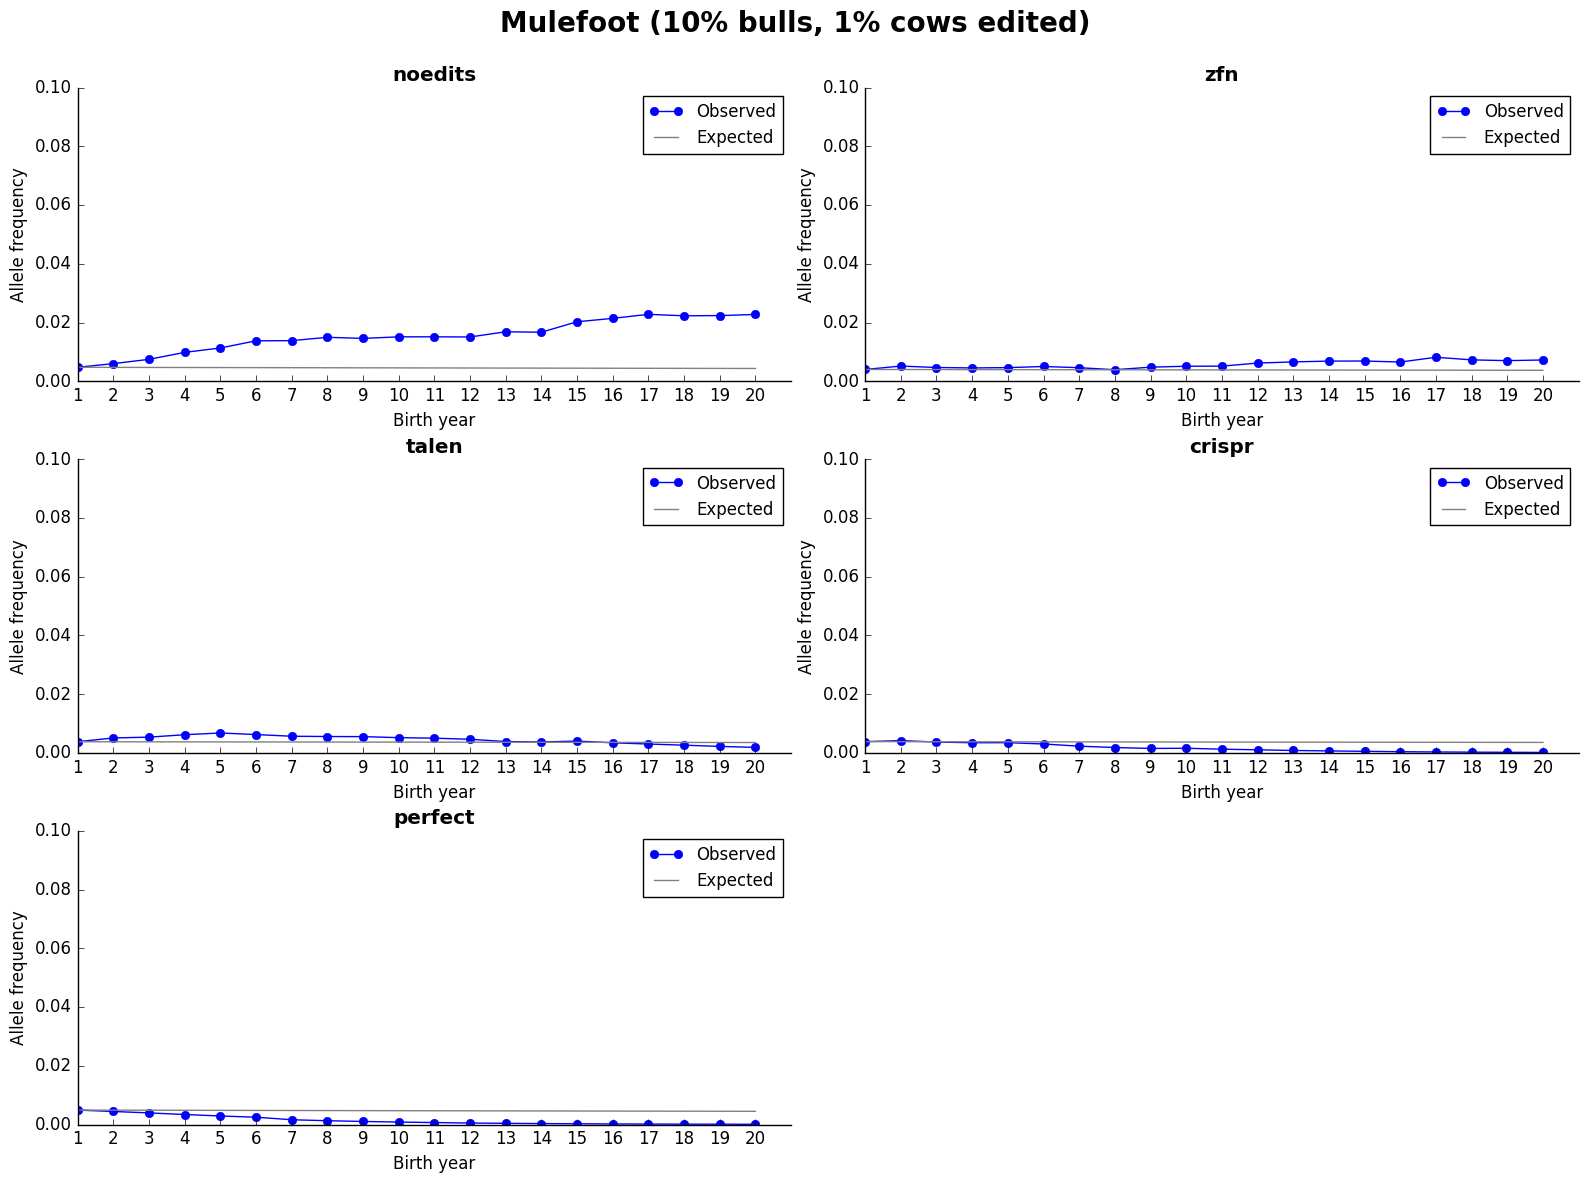

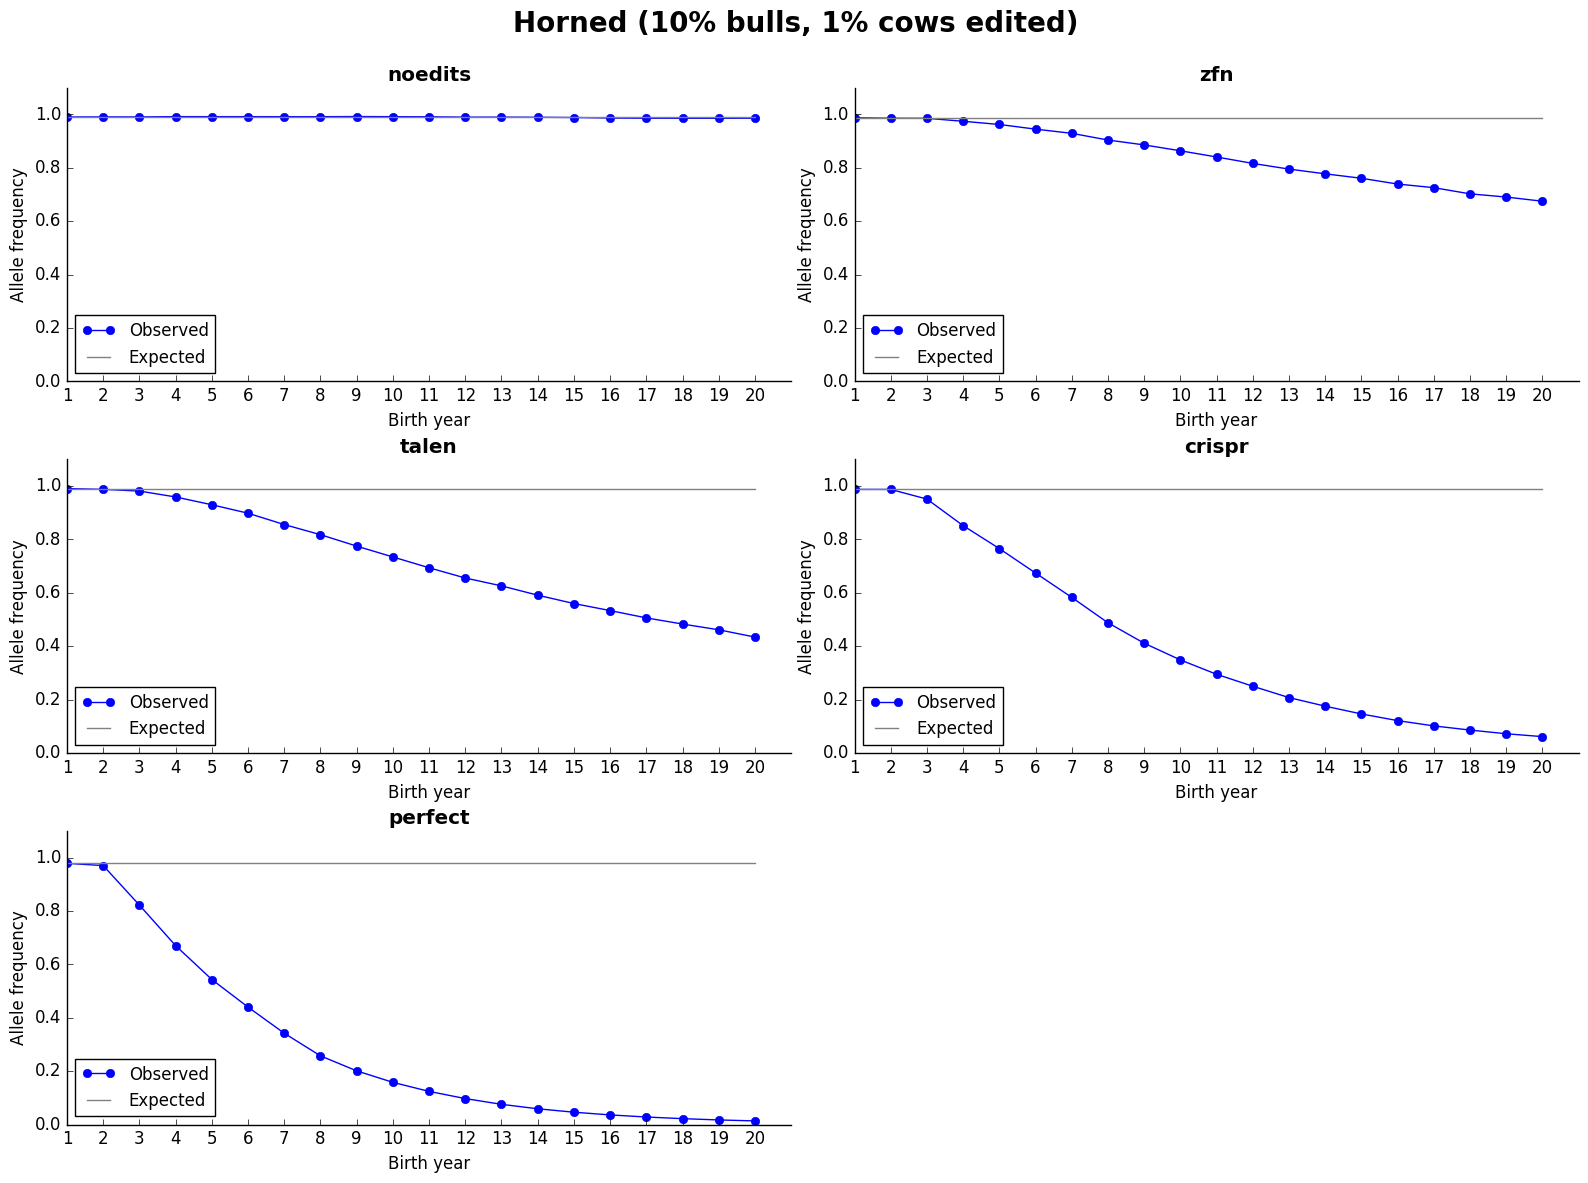

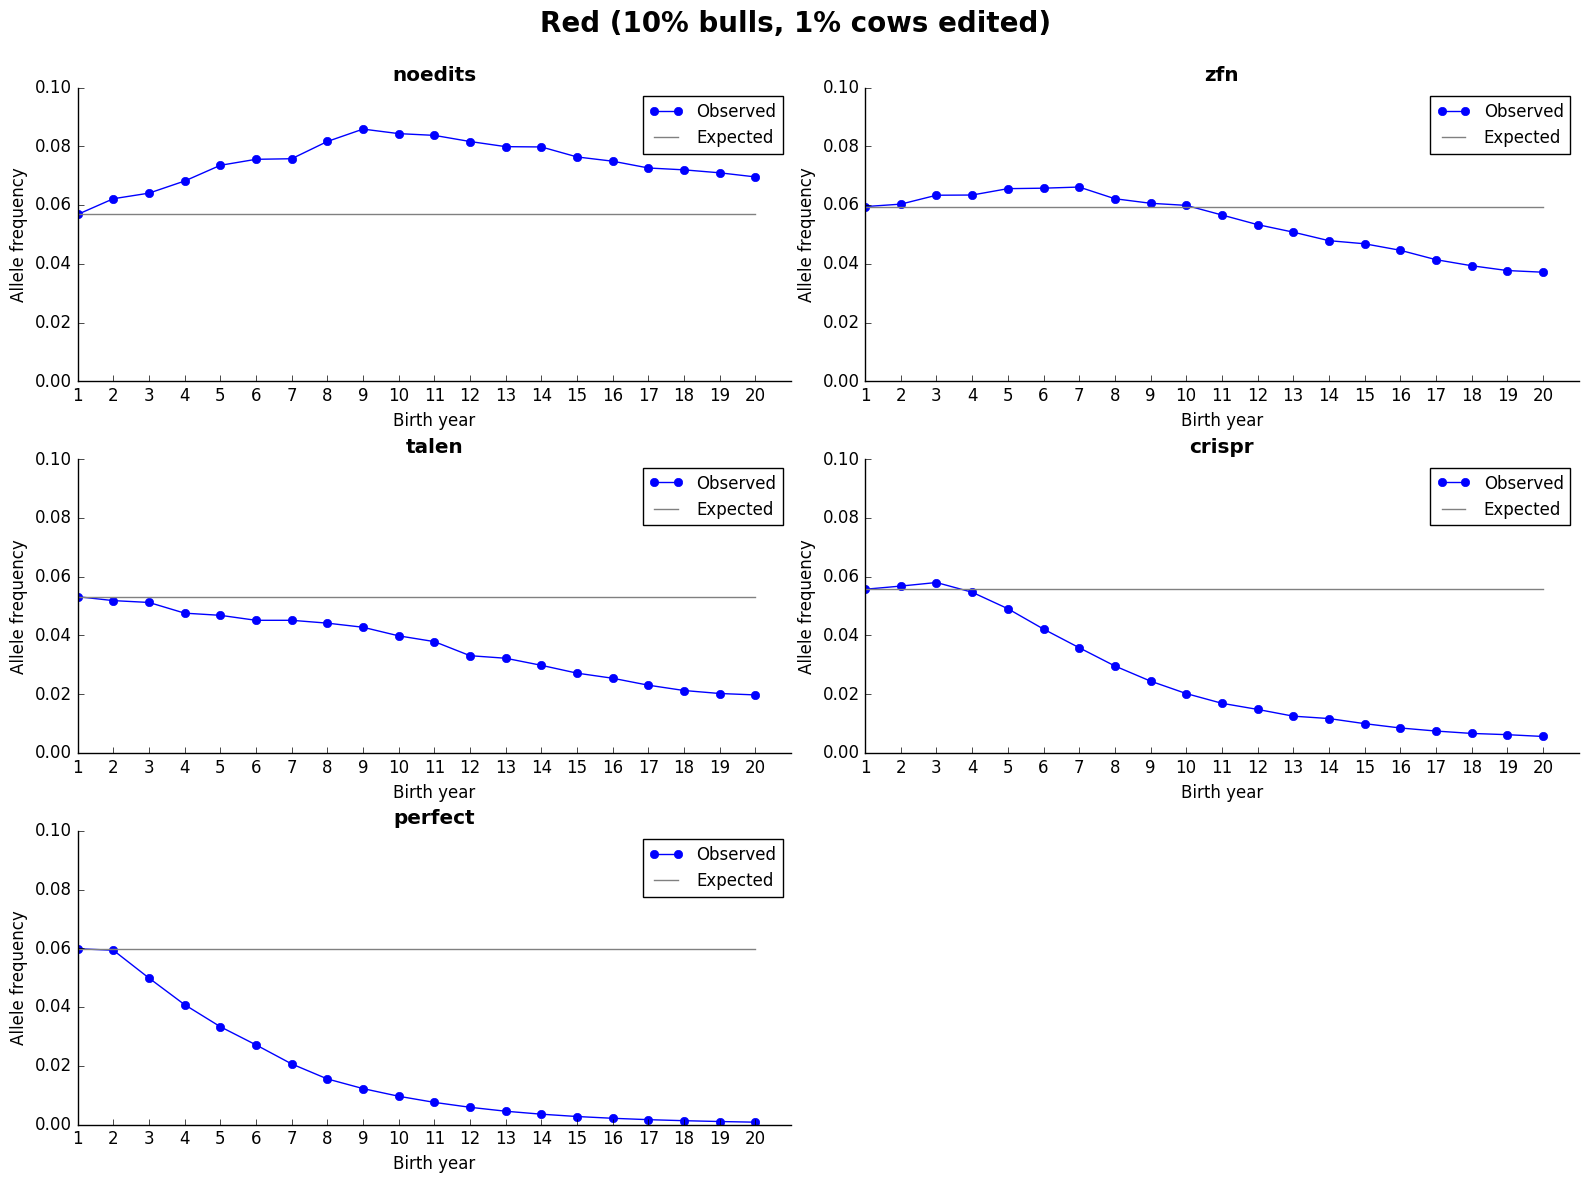

In [70]:
xlabels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
colors = itertools.cycle(['r', 'g', 'b'])
for r in ['Brachyspina', 'HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'BLAD', 'CVM', 'DUMPS', 'Mulefoot', 'Horned', 'Red']:
    fig = plt.figure(figsize=(16, 12), dpi=300, facecolor='white')
    for i, m in enumerate(methods):
        ax = fig.add_subplot(3, 2, i+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)  
        ax.set_title(m, weight='bold')
        ax.set_xlabel('Birth year')
        ax.set_ylabel('Allele frequency')
        ax.plot(actual[r][m], label='Observed', marker='o', c='b', mec='b')
        ax.plot(expected[r][m], label='Expected', c='gray')
        if r == 'Horned':
            ax.set_ylim(0.0, 1.1)
        else:
            ax.set_ylim(0.0, 0.10)
        ax.set_xlim(0, 20)
        # Manually set the number of ticks on the plot
        ax.set_xticks(np.arange(20))
        # Apply the tick labels
        ax.set_xticklabels(xlabels)
        # Turn off the top and right tick marks
        plt.tick_params(
            axis='both',       # changes apply to both axes
            which='both',      # both major and minor ticks are affected
            right='off',
            labelright='off',
            top='off',         # ticks along the top edge are off
            labeltop='off')    # labels along the bottom edge are off
        # Place the legend
        ax.legend(loc='best')
    # Use the recessive name as the title for each set of subplots
    plt.suptitle('%s (10%% bulls, 1%% cows edited)'%r, fontsize=20, weight='bold')
    plt.tight_layout(pad=1., w_pad=0.5, h_pad=0.95)
    # Tweak the layout so that the subplot titles don't overlap because tight_layout()
    # ignores suptitle().
    plt.subplots_adjust(top=0.915)
    plt.show()
    filename = 'holstein-act-vs-exp-%s-by-method_10_01.png' % ( r )
    fig.savefig(filename, dpi=300)

Now we're going to regress frequency on birth year to estimate trend.

In [74]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def fit_line(x, y):
    """Return RegressionResults instance of best-fit line."""
    #X = sm.add_constant(x)
    data = {'x':np.array(x), 'y':np.array(y)}
    fit = smf.ols(formula = 'y ~ x + I(x**2)', data=data).fit()
    print fit.summary()
    
    prstd, iv_l, iv_u = wls_prediction_std(fit)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x, y, 'o', label="data")
    ax.plot(x, fit.fittedvalues, 'r', label="OLS")
    ax.plot(x, iv_u, 'r--')
    ax.plot(x, iv_l, 'r--')
    ax.legend(loc='best');
    ax.set_ylim(0.0, 0.10)
    ax.set_xlim(0., 20.)
    plt.show()
    
    return fit



==>  noedits
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     261.0
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           1.74e-13
Time:                        16:31:37   Log-Likelihood:                 108.69
No. Observations:                  20   AIC:                            -211.4
Df Residuals:                      17   BIC:                            -208.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0387      0.001     

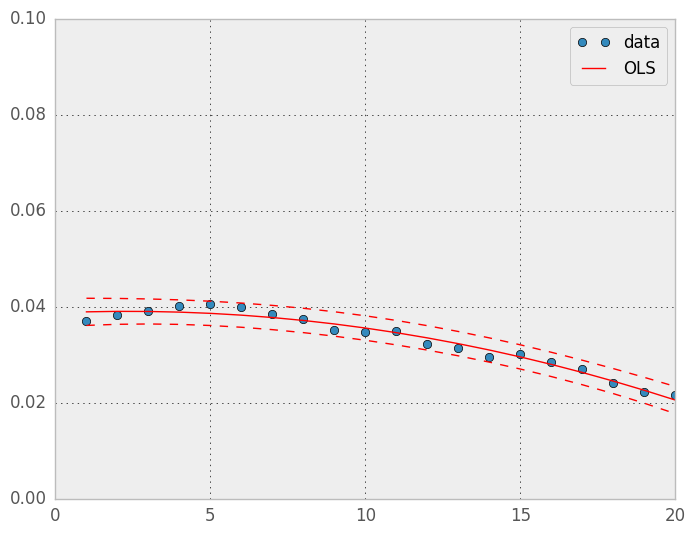



==>  zfn
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     101.7
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           3.49e-10
Time:                        16:31:37   Log-Likelihood:                 103.47
No. Observations:                  20   AIC:                            -200.9
Df Residuals:                      17   BIC:                            -198.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0326      0.001     29.4

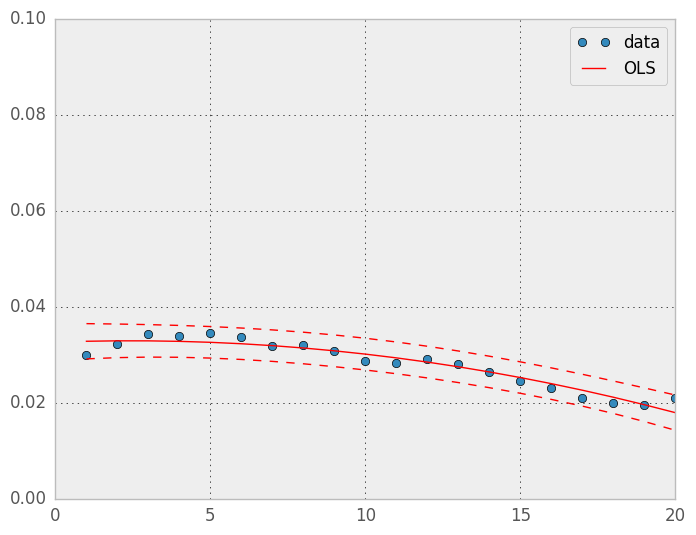



==>  talen
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     79.80
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           2.29e-09
Time:                        16:31:37   Log-Likelihood:                 104.35
No. Observations:                  20   AIC:                            -202.7
Df Residuals:                      17   BIC:                            -199.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0362      0.001     34

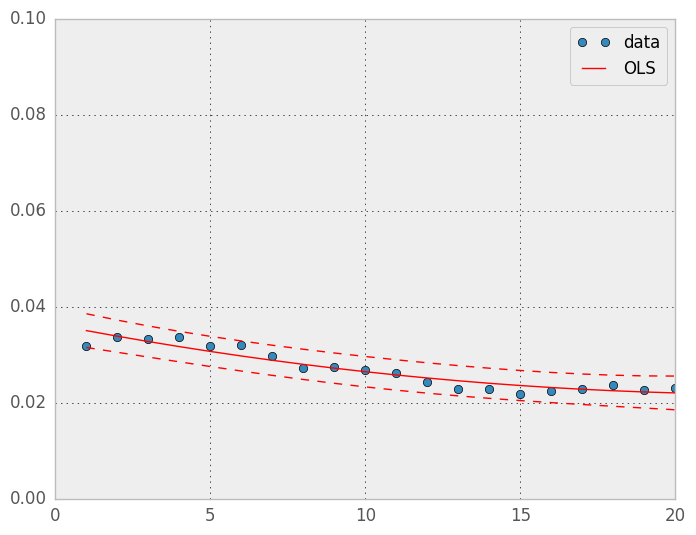



==>  crispr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     328.0
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           2.63e-14
Time:                        16:31:38   Log-Likelihood:                 97.127
No. Observations:                  20   AIC:                            -188.3
Df Residuals:                      17   BIC:                            -185.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0421      0.002     2

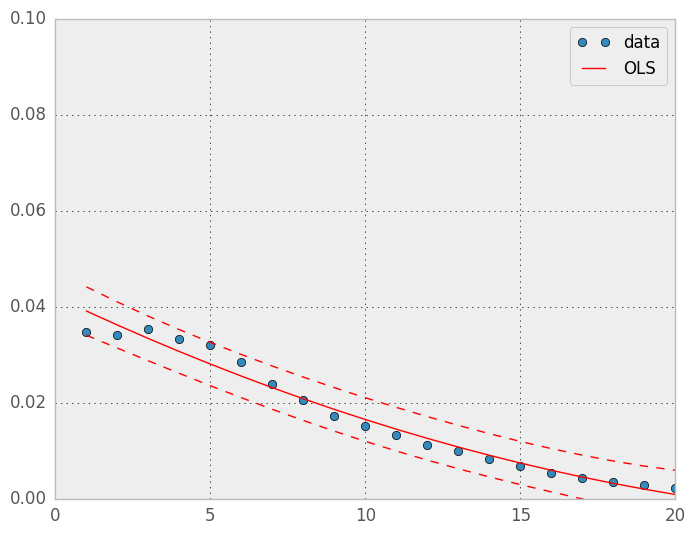



==>  perfect
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     920.3
Date:                Tue, 24 Jan 2017   Prob (F-statistic):           4.71e-18
Time:                        16:31:38   Log-Likelihood:                 108.45
No. Observations:                  20   AIC:                            -210.9
Df Residuals:                      17   BIC:                            -207.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0406      0.001     

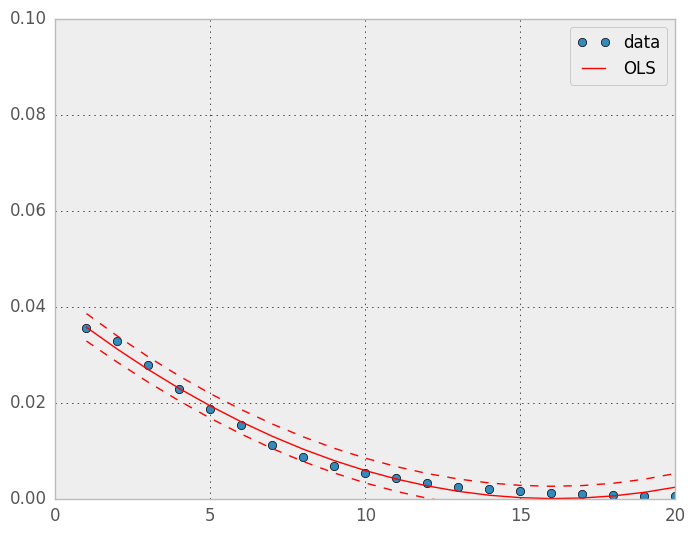

In [75]:
fits = {}
years = [float(i) for i in xrange(1,21)]
for r in ['HH3']:
    fits[r] = {}
    for m in methods:
        print '\n\n==> ', m
        fit = fit_line(y=actual[r][m], x=years)
        fits[r][m] = fit

In [12]:
#import dask.dataframe as dd
methods = ['crispr', 'noedits', 'perfect', 'talen', 'zfn']
for method in methods:
    print method
    # We have 10 replicates for each simulation
    for sim in xrange(1,11):
        if sim == 1: print '\tReplicate: ', sim,
        elif sim < 10: print ', ', sim,
        else: print ', ', sim, ''
        # Load the individual history files
        #print '\t\tReading live cows.'
        lc = pd.read_csv('multiple/10_01/%s/%s/cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading dead cows.'
        dc = pd.read_csv('multiple/10_01/%s/%s/dead_cows_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading live bulls.'
        lb = pd.read_csv('multiple/10_01/%s/%s/bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        #print '\t\tReading dead bulls.'
        db = pd.read_csv('multiple/10_01/%s/%s/dead_bulls_history_%s_20.txt'%(method,sim,method), sep='\t')
        # Stack the individual animal datasets
        #print '\t\tConcatenating animal datasets'
        all_animals = pd.concat([lc, dc, lb, db], axis=0)
        all_animals['replicate'] = sim
        all_animals['method'] = method
        if method == methods[0] and sim == 1:
            #print '\t\tCreating initial dataframe for replicates.'
            #all_replicates = all_animals
            grouped = all_animals.groupby(['born', 'method']).mean().reset_index()
        else:
            #print '\t\tCreating successive dataframe for replicates.'
            grouped = pd.concat([grouped, all_animals.groupby(['born', 'method']).mean().reset_index()])

crispr
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
noedits
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
perfect
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
talen
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 
zfn
	Replicate:  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  10 


In [18]:
all_replicates['method'].value_counts()

noedits    2400
crispr     2400
zfn        2400
talen      2400
perfect    2400
Name: method, dtype: int64

In [19]:
#grouped = all_replicates.groupby(['born', 'method']).mean().reset_index()
grouped.head()

born  method        animal  sire  dam        herd      died         TBV  \
0    -9  crispr  35177.425000   0.0  0.0   98.100000  1.250000  320.052402   
0    -9  crispr  35188.458333   0.0  0.0  116.333333  1.166667  288.709654   
0    -9  crispr  35198.470588   0.0  0.0   95.647059  1.411765  295.519279   
0    -9  crispr  35170.771429   0.0  0.0   99.828571  1.285714  348.068456   
0    -9  crispr  35195.363636   0.0  0.0   88.848485  1.272727  309.324233   

   inbreeding  replicate  
0         0.0        1.0  
0         0.0        2.0  
0         0.0        3.0  
0         0.0        4.0  
0         0.0        5.0

In [20]:
grouped.sort_values(by=['method','born'], inplace=True)

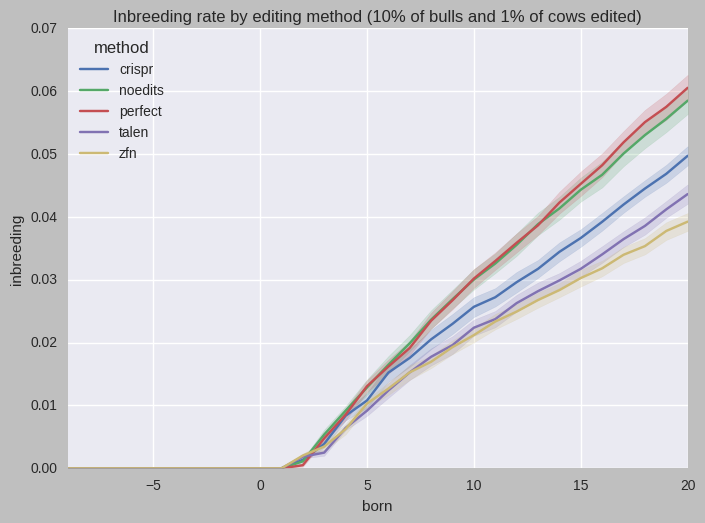

In [21]:
# Plot inbreeding by method
sns.set(style="darkgrid")
sns_plot = sns.tsplot(data=grouped, time="born", unit="replicate", condition="method", value="inbreeding")
sns.plt.title('Inbreeding rate by editing method (10% of bulls and 1% of cows edited)')
plt.show()
sns_plot.get_figure().savefig('multiple/10_01/rate_of_inbreeding_change_multiple_10_01.png', dpi=300)

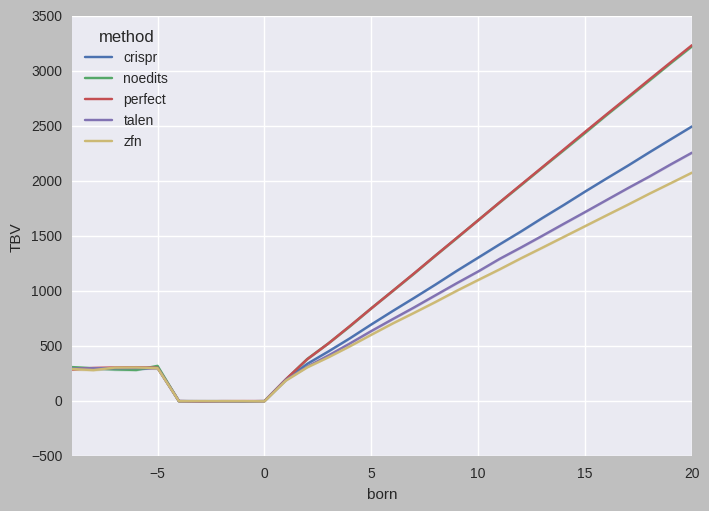

In [22]:
sns.tsplot(data=grouped, time="born", unit="replicate", condition="method", value="TBV")
plt.show()

In [23]:
# http://stackoverflow.com/questions/22650833/pandas-groupby-cumulative-sum
grouped['TBV_cumulative'] = grouped.groupby(['method'])['TBV'].apply(lambda x: x.cumsum())

In [24]:
grouped.describe()

born        animal          sire           dam         herd  \
count  1500.000000  1.500000e+03  1.500000e+03  1.500000e+03  1500.000000   
mean      5.500000  6.100504e+05  4.703636e+05  4.586681e+05    99.563006   
std       8.658328  6.180284e+05  5.423318e+05  5.314285e+05     4.322073   
min      -9.000000  1.728554e+04  0.000000e+00  0.000000e+00    71.962963   
25%      -2.000000  3.517558e+04  0.000000e+00  0.000000e+00    99.231694   
50%       5.500000  3.929561e+05  1.868443e+05  1.849462e+05    99.692606   
75%      13.000000  1.142723e+06  9.136044e+05  8.909700e+05   100.114542   
max      20.000000  1.844686e+06  1.675237e+06  1.593832e+06   126.560976   

              died          TBV   inbreeding    replicate  TBV_cumulative  
count  1500.000000  1500.000000  1500.000000  1500.000000     1500.000000  
mean      7.808969  1009.314235     0.017210     5.500000    81553.294698  
std       5.136742   895.592726     0.018293     2.873239    87675.311987  
min       1.000000    -7.065866     0.000000     1.000000      269.818073  
25%       3.261593   282.573522     0.000000     3.000000    15102.640614  
50%       6.495412   778.405883     0.011784     5.500000    38564.947164  
75%      13.005949  1695.777382     0.031849     8.000000   132724.423150  
max      15.379740  3275.229751     0.070949    10.000000   360604.306881

In [25]:
grouped['method'].value_counts()

zfn        300
talen      300
noedits    300
perfect    300
crispr     300
Name: method, dtype: int64

In [33]:
for method in grouped['method'].value_counts().keys():
    print method, 'mean: ', grouped.loc[(grouped['method'] == method) & (grouped['born'] == 20)]['TBV_cumulative'].mean(),
    print 'stderr: ', grouped.loc[(grouped['method'] == method) & (grouped['born'] == 20)]['TBV_cumulative'].std()

import scipy.stats as stats
for pop1 in grouped['method'].value_counts().keys():
    for pop2 in grouped['method'].value_counts().keys():
        if pop1 != pop2:
            print pop1, ' ', pop2
            print stats.ttest_ind(a=grouped.loc[(grouped['method'] == pop1) & (grouped['born'] == 20)]['TBV_cumulative'],
                            b=grouped.loc[(grouped['method'] == pop2) & (grouped['born'] == 20)]['TBV_cumulative'],
                            equal_var=False)

zfn mean:  235045.754069 stderr:  6309.36132342
talen mean:  251703.779485 stderr:  6859.47794086
noedits mean:  345283.385014 stderr:  9768.11499647
perfect mean:  346050.437728 stderr:  9804.53554549
crispr mean:  276025.745195 stderr:  7569.17149274
zfn   talen
Ttest_indResult(statistic=-5.6521335259772609, pvalue=2.376428202212471e-05)
zfn   noedits
Ttest_indResult(statistic=-29.97801027915013, pvalue=4.4795816926825592e-15)
zfn   perfect
Ttest_indResult(statistic=-30.107349956596195, pvalue=4.4256254424838588e-15)
zfn   crispr
Ttest_indResult(statistic=-13.151078083626219, pvalue=1.7502916385546324e-10)
talen   zfn
Ttest_indResult(statistic=5.6521335259772609, pvalue=2.376428202212471e-05)
talen   noedits
Ttest_indResult(statistic=-24.792582767273444, pvalue=2.8108250892640271e-14)
talen   perfect
Ttest_indResult(statistic=-24.933502413901856, pvalue=2.6883858494323784e-14)
talen   crispr
Ttest_indResult(statistic=-7.5294504111842286, pvalue=6.1069900765109001e-07)
noedits   zfn
T

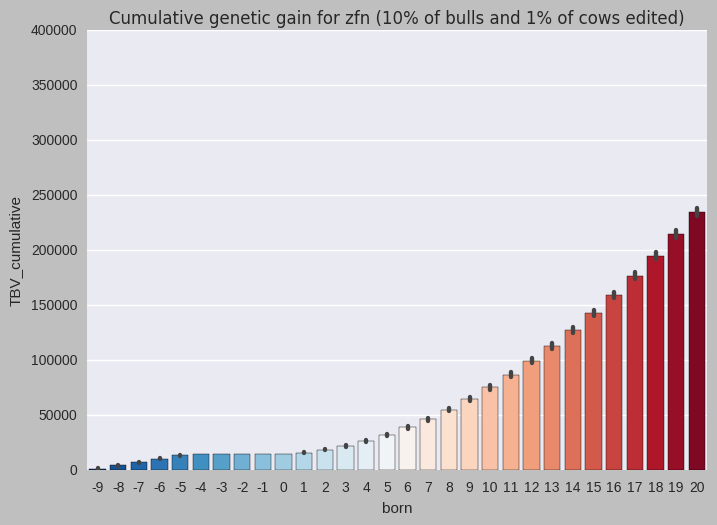

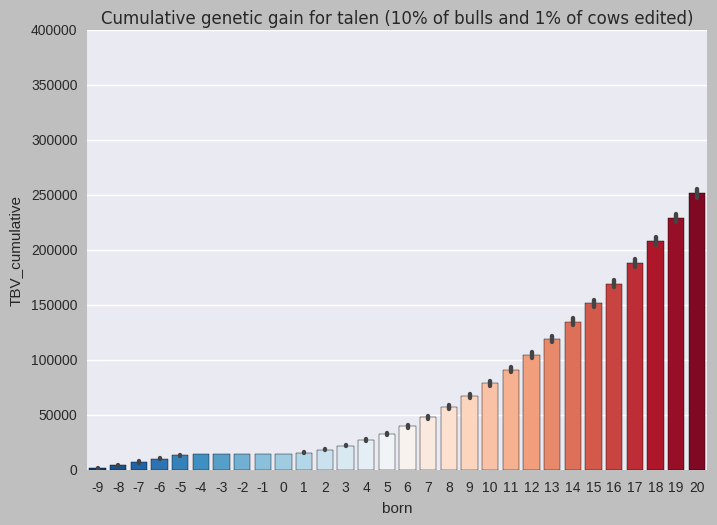

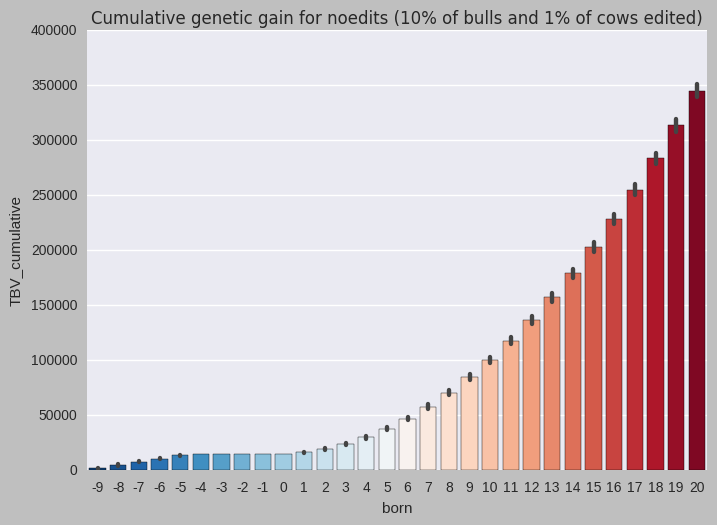

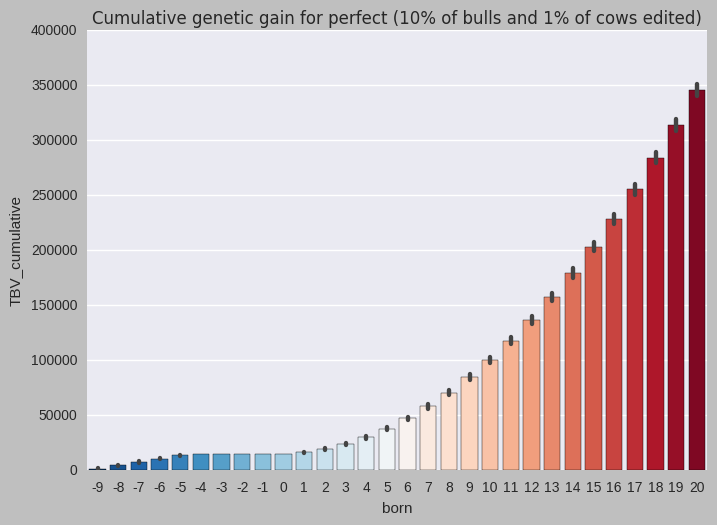

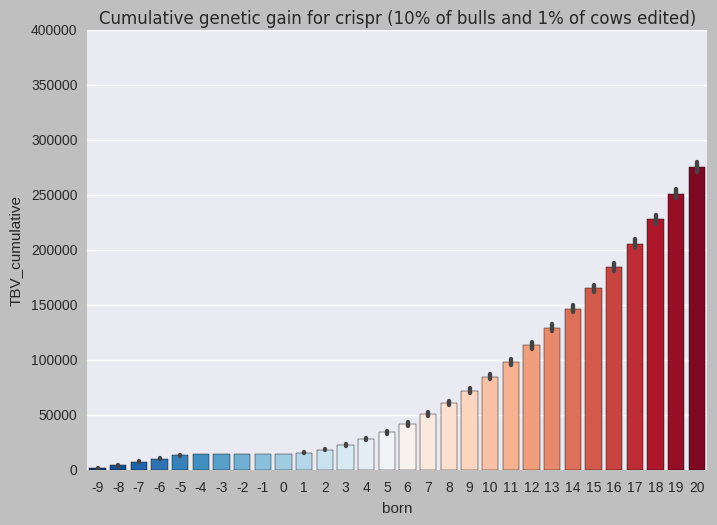

In [37]:
sns.set(style="darkgrid")
for method in grouped['method'].value_counts().keys():
    sns_plot = sns.barplot(grouped[grouped['method'] == method]['born'],
                grouped[grouped['method'] == method]['TBV_cumulative'],
                palette="RdBu_r")
    plt.ylim(0,400000)
    plt.title(method)
    sns.plt.title('Cumulative genetic gain for %s (10%% of bulls and 1%% of cows edited)'%(method))
    sns_plot.get_figure().savefig('multiple/10_01/genetic_gain_multiple_%s_10_01.png'%(method), dpi=300)
    plt.show()